In [3]:
import argparse
import random
from typing import Literal
from pathlib import Path

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import intel_extension_for_pytorch as ipex
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from PIL import Image
from PIL.ImageFile import ImageFile

from tqdm import tqdm
from torchvision import transforms as T

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data_pth = Path('../../data/extracted_masks')

In [5]:
timesteps = Path('../../data/grade_timesteps.csv')

timesteps_df = pd.read_csv(timesteps)

In [6]:
timesteps_df.groupby('id').apply(lambda x: x['dt'].diff().dropna().mean()).loc['D2017.11.01_S01644_I0149_D_9']

/tmp/ipykernel_8079/375113948.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  timesteps_df.groupby('id').apply(lambda x: x['dt'].diff().dropna().mean()).loc['D2017.11.01_S01644_I0149_D_9']


0.010453709605045023

In [7]:
# sed 400 weird
random.seed(4876677)

sample_pth = random.choice(list(data_pth.glob('*')))

In [8]:

sample_pth

PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

In [9]:
all_masks = np.load(sample_pth/'zps.npy')
all_masks_inner = np.load(sample_pth/'mask_inner.npy')
all_masks_whole = np.load(sample_pth/'mask_whole.npy')

In [10]:
scale_pixel_microm = 1.7/2 # 1.7 pixels to μm

In [11]:
dt = 0.010453709605045023*24

In [12]:
dt

0.2508890305210806

In [13]:
nframes = all_masks.shape[0]

In [14]:
all_masks[-1]>0.5

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

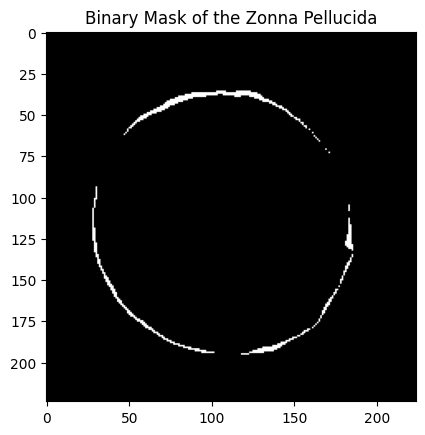

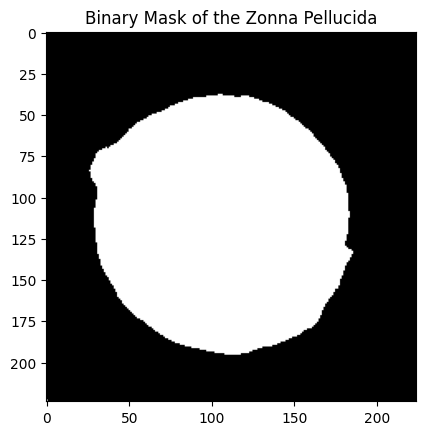

Text(0.5, 1.0, 'Binary Mask of the Zonna Pellucida')

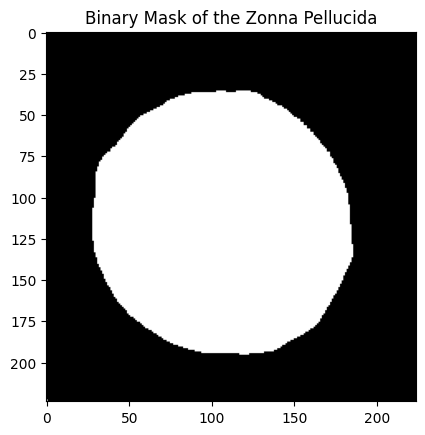

In [15]:
plt.imshow(all_masks[-1][0]>0.5, cmap='gray')
plt.title("Binary Mask of the Zonna Pellucida")
plt.show()
plt.imshow(all_masks_inner[-1][0]==1, cmap='gray')
plt.title("Binary Mask of the Zonna Pellucida")
plt.show()
plt.imshow(all_masks_whole[-1][0]==1, cmap='gray')
plt.title("Binary Mask of the Zonna Pellucida")

In [16]:
def calculate_radiuses(x_coords, y_coords):
    # Calculate the distances of all white boundary pixels from the circle center
    distances = np.sqrt((x_coords - xc)**2 + (y_coords - yc)**2)
    # remove extremes
    q_001 = distances>=np.quantile(distances, q=0.1)
    q_099= distances<=np.quantile(distances, q=0.90)
    distances= distances[(q_001&q_099)]
    # Find the "true" outer radius based on the maximal distances (fullest thickness)
    outer_radius = np.max(distances)
    inner_radius = np.min(distances)
    # Compute the thickness as the difference
    thickness_values = distances - radius  # Thickness at each point
    thickness_mean = np.mean(thickness_values[thickness_values > 0])  # Exclude artifacts (negative values)
    thickness_variance = np.var(thickness_values[thickness_values > 0])

    return outer_radius, inner_radius, thickness_mean, thickness_variance, distances


In [17]:
from scipy.optimize import leastsq
def algebraic_circle_fit(x, y):
    """
    Perform least-squares fitting of a circle to given (x, y) points.
    Returns the center (xc, yc) and radius r.
    """
    def calc_radius(xc, yc):
        return np.sqrt((x - xc)**2 + (y - yc)**2)

    def cost(params):
        xc, yc = params
        radii = calc_radius(xc, yc)
        return radii - radii.mean()

    # Initial guess for the center
    x_m, y_m = np.mean(x), np.mean(y)
    center, _ = leastsq(cost, (x_m, y_m))
    xc, yc = center
    radii = calc_radius(xc, yc)
    r = radii.mean()
    return xc, yc, r


In [18]:
from pydantic import BaseModel

class FittedMaskResults(BaseModel):
    inner_radius: float
    mean_thickess: float
    thickness_std: float
    outer_radius: float
    circle_center: tuple[float,float]
    area: float
    nframe: int

In [19]:
import scipy.ndimage as ndi
def choose_largest_blob(binary_image: np.ndarray) -> np.ndarray:

    binary_image = binary > 0  # Convert to boolean mask

    # Label connected components
    labeled_array, num_features = ndi.label(binary)

    # Measure area of each labeled region
    sizes = ndi.sum(binary, labeled_array, range(1, num_features + 1))

    # Find the label of the largest connected component
    largest_label = np.argmax(sizes) + 1  # Labels start from 1

    # Create a mask for the largest component
    largest_component = labeled_array == largest_label

    # Convert back to uint8 image if needed
    largest_component_img = (largest_component * 255).astype(np.uint8)

    return largest_component_img

In [20]:
import numpy as np
def fit_masks(zp_mask: np.ndarray, ) -> FittedMaskResults:

    y_coords, x_coords = np.where(choose_largest_blob(zp_mask))

    xc, yc, radius = algebraic_circle_fit(x_coords, y_coords)

    outer_radius, inner_radius, thickness_mean, thickness_variance, distances = calculate_radiuses(x_coords, y_coords)

    return outer_radius, inner_radius, thickness_mean, thickness_variance, distances
    

In [21]:
# Define the angular intervals for measuring thickness
import numpy as np
angles = np.linspace(0, 2 * np.pi, 360)  # 360 angular intervals
mean_thicknesses = []
radii = []
outter_radii = []
circle_centers = []
area = []

fitted_results: list[FittedMaskResults] = []
for i in range(nframes):
    thicknesses = []
    binary = all_masks[i,0]==1

    area.append((all_masks_whole[i,0]==1).sum())

    y_coords, x_coords = np.where(binary == True)

    xc, yc, radius = algebraic_circle_fit(x_coords, y_coords)

    outer_radius, inner_radius, thickness_mean, thickness_variance, distances = fit_masks(zp_mask=all_masks[i,0]==1)
    fitted_res = FittedMaskResults(
                            inner_radius=inner_radius,
                            outer_radius=outer_radius,
                            mean_thickess=thickness_mean,
                            thickness_std=thickness_variance,
                            area=(all_masks_inner[i,0]==1).sum(),
                            circle_center=(xc, yc),
                            nframe=i
                            )
    fitted_results.append(fitted_res)
    continue
    # outer_radius, inner_radius, thickness_mean, thickness_variance, distances = calculate_radiuses(x_coords, y_coords)
    
    # Iterate over each angle and calculate true thickness
    for angle in angles:
        # Compute ray endpoints based on the angle
        ray_x = int(xc + outer_radius * np.cos(angle))
        ray_y = int(yc + outer_radius * np.sin(angle))
        
        # Traverse along the ray to find outer and inner boundary points
        points_on_ray = []
        for t in np.linspace(0, outer_radius, 500):
            x = int(xc + t * np.cos(angle))
            y = int(yc + t * np.sin(angle))
            if 0 <= x < binary.shape[1] and 0 <= y < binary.shape[0]:
                if binary[y, x] == True:
                    points_on_ray.append((x, y))
        
        # If points are found, calculate distances to the center
        if len(points_on_ray) > 1:
            distances = [np.sqrt((px - xc)**2 + (py - yc)**2) for px, py in points_on_ray]
            thickness = max(distances) - min(distances)  # True thickness
            thicknesses.append(thickness)
        else:
            continue
    

    mean_thicknesses.append((np.mean(thicknesses), np.std(thicknesses)))
    radii.append(inner_radius)
    outter_radii.append(outer_radius)
    circle_centers.append((xc,yc))
    # Convert angles to degrees for plotting
    angles_deg = np.degrees(angles)

    # Plot the thickness profile
    # plt.figure(figsize=(8, 4))
    # plt.plot(angles_deg, thicknesses)
    
# plt.xlabel("Angle (degrees)")
# plt.ylabel("True Thickness (pixels)")
# plt.title("True Thickness Along the Circle")
# plt.grid(True)
# plt.show()


In [88]:
class Calculator:

    @staticmethod
    def calculate_J(lambda1: float, lambda2: float, lambda3: float) -> float:
        return lambda1*lambda2*lambda3


    @staticmethod
    def calculate_radial_strech(r: float, R: float) -> float:
        # lambda1
        return r/R #1+(r-R)/R

    @staticmethod
    def calculate_circ_strech(l: float, L: float) -> float:
        #lambda2
        return l/L#1+(l-L)/L

    @staticmethod
    def sphere_volume(r: float) -> float:
        return 4*np.pi*r**3/3

    @staticmethod
    def calculate_zp_volume(inner_radius: float, outer_radius: float):
        return Calculator.sphere_volume(outer_radius)- Calculator.sphere_volume(inner_radius)

    @staticmethod
    def calculate_J_2(V_0: float, V_deformed: float):
        return V_deformed/V_0

    @staticmethod
    def calculate_lambda2(lambda1: float, lambda3: float, J: float) -> float:
        return (lambda1*lambda3)/J

In [89]:
class OdgenParameters(BaseModel):
    order: int 
    mi: float
    alpha: float 


class FrameModelParams(BaseModel):
    lambda1: float
    lambda2: float
    lambda3: float
    J: float

In [90]:
def get_shear_modulus(E, v):
    return E/2/(1+v)

def get_bulk_modulus(E, v):
    return E/3/(1-2*v)

In [91]:
inner_radius_all =np.array( [1e-6*frame.inner_radius/scale_pixel_microm for frame in fitted_results])
outer_radius_all = np.array([1e-6*frame.outer_radius/scale_pixel_microm for frame in fitted_results])

In [92]:
time_v = np.array([dt]*nframes)
time_v[0] = 0
time_v = np.cumsum(time_v)

In [93]:
import numpy as np
from scipy.optimize import curve_fit


def fit_func(x, a, b, c, d): 
    return a*x**3 + b*x**2 +c*x+d

In [94]:
# WHY ARE THEY INVERSE?
params_outer = curve_fit(fit_func, time_v,outer_radius_all )

params_inner = curve_fit(fit_func, time_v, inner_radius_all)

In [95]:
fitted_inner = fit_func(time_v, *params_inner[0])


fitted_outer = fit_func(time_v, *params_outer[0])   

Text(0, 0.5, 'Radius (m)')

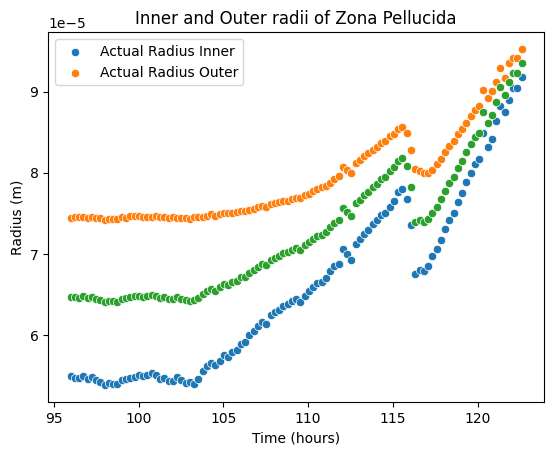

In [96]:
import seaborn as sns
# sns.lineplot(x=time_v+24*4,y=fitted_inner, lw=1)

# sns.lineplot(x=time_v+24*4,y=fitted_outer, lw=1)
sns.scatterplot(x=time_v+24*4,y=inner_radius_all, lw=0.5)

sns.scatterplot(x=time_v+24*4,y=outer_radius_all, lw=0.5, )

sns.scatterplot(x=time_v+24*4,y=(outer_radius_all+inner_radius_all)/2, lw=0.5, )
plt.legend(['Actual Radius Inner', 'Actual Radius Outer'])

plt.title('Inner and Outer radii of Zona Pellucida')
plt.xlabel('Time (hours)')
plt.ylabel('Radius (m)')

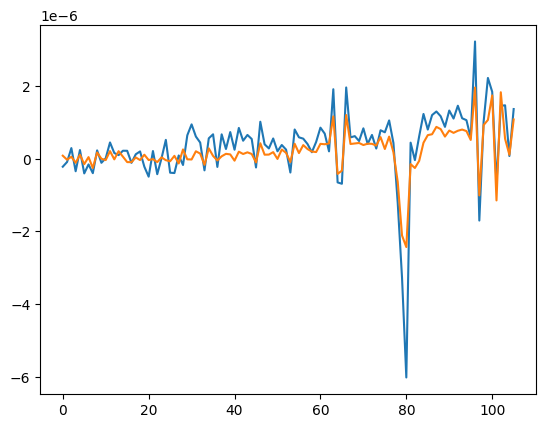

In [97]:
plt.plot(np.diff(inner_radius_all))
plt.plot(np.diff(outer_radius_all))

In [98]:
# V_0 = Calculator.calculate_zp_volume(fitted_results[0].inner_radius, fitted_results[0].outer_radius)
# R_0 = fitted_results[0].inner_radius
# circ_0 = 2*np.pi*R_0

# t_0 = fitted_results[0].outer_radius-fitted_results[0].inner_radius

# # r0 = fitted_results[0].inner_radius
# pressures = []
# J_s = []
# lambda1s = []
# radial_strain = []
# circ_strain = []

# lambda2s = []
# lambda3s = []
# volumes = []

# for frame in fitted_results[1:]:

#     V_deformed = Calculator.calculate_zp_volume(frame.inner_radius, frame.outer_radius)
#     lambda1 =  Calculator.calculate_radial_strech(frame.outer_radius-frame.inner_radius, t_0)
#     lambda2 =Calculator.calculate_circ_strech(2*np.pi*frame.inner_radius, circ_0)
#     lambda3 = lambda2
#     J =  Calculator.calculate_J(lambda1, lambda2, lambda3)
#     lambda2 = Calculator.calculate_lambda2(lambda1, lambda3, J)
#     lambda1s.append(lambda1)
#     lambda2s.append(lambda2)
#     lambda3s.append(lambda3)

#     # J_s.append(J)
#     J_s.append(lambda1*lambda2*lambda3)
#     volumes.append(V_deformed)
#     pressures.append(pressure_aprox(frame.inner_radius, frame.outer_radius-frame.inner_radius))

#     radial_strain.append(((frame.outer_radius-frame.inner_radius)-t_0)/t_0)

#     circ_strain.append((2*np.pi*frame.inner_radius-circ_0)/circ_0)

In [99]:
E =1000
v= 0.15
G = get_shear_modulus(E,v)
K = get_bulk_modulus(E,v)

def calc_c(thickness: float, E: float, R_0):
    return E*thickness*(R_0+thickness)**2/np.pi

def pressure_aprox(r: float, thickness: float, R_0: float, E: float):
    C = calc_c(thickness, E, R_0)
    return C*(1-(R_0/r)**6)/(R_0+thickness)**2/r


In [100]:
import numpy as np

def balloon_pressure_gent_compressible_known_thickness(
    thickness,    # the *current* thickness, which you already know
    radius,       # current outer radius (r)
    radius0,      # initial radius (r0)
    E,            # small-strain Young's modulus
    nu,           # Poisson's ratio
    Jm,           # Gent parameter
    bulk_modulus=None
):
    """
    Compute internal pressure for a thin spherical balloon
    using a compressible Gent model, assuming you already know 
    the current thickness and the out-of-plane stretch is *not*
    solved for plane-stress.

    Returns
    -------
    float
        Internal pressure.
    """
    # In-plane stretches
    lam = radius / radius0
    
    # Shear modulus
    mu = E / (2.0 * (1.0 + nu))
    
    # Bulk modulus if not provided
    if bulk_modulus is None:
        bulk_modulus = E / (3.0 * (1.0 - 2.0 * nu))
    
    # For simplicity, assume the out-of-plane stretch lam3 is unknown or 
    # you've effectively folded it into 'thickness'. We'll define:
    # J = lam^2 * lam3  (but we don't solve for lam3).
    # Instead, let’s pick an approximate lam3 by t / t0 if you *also* know the initial thickness,
    # or just treat lam3 as a user-known input if needed. 
    # For demonstration, we assume lam3=1 or anything you want— not relevant 
    # if thickness is already given. 
    lam3 = 1.0
    
    # "Nominal" volumetric ratio (approx) 
    J = lam * lam * lam3
    
    # Deviatoric stretches
    J23 = J**(-1.0/3.0)
    bar_lam1 = lam * J23
    bar_lam2 = lam * J23
    bar_lam3 = lam3 * J23
    
    # I1_bar for Gent
    I1_bar = bar_lam1**2 + bar_lam2**2 + bar_lam3**2
    
    # Check Gent limit
    denom_dev = 1.0 - (I1_bar - 3.0)/Jm
    if denom_dev <= 0.0:
        return float('inf')
    
    # Deviatoric stress in the hoop direction 
    # (neo-Hookean approach for compressible uses 2 * dW_dev/dI1 * bar_lam * chain rule, etc.)
    # For simplicity, a direct approach:
    sigma_dev_hoop = mu * (bar_lam1**2 - bar_lam3**2) / denom_dev  # approximate for a "hoop" direction if lam1=lam2
    
    # Volumetric stress contribution
    sigma_vol = bulk_modulus * (J - 1.0)
    
    # So total hoop stress
    sigma_hoop = sigma_dev_hoop + sigma_vol
    
    # Finally, thin-shell approximation for pressure: 
    #   P = 2 * (hoop stress) * (current thickness) / (current radius).
    P = 2.0 * sigma_hoop * thickness / radius
    
    return P


In [101]:
def balloon_pressure_gent(thickness, radius, radius0, young_modulus, Jm):
    """
    Compute the internal pressure of a thin spherical balloon using the Gent model.
    
    Parameters
    ----------
    thickness      : float  (initial balloon thickness, t0)
    radius         : float  (current outer radius of the balloon, r)
    radius0        : float  (initial/uninflated radius, r0)
    young_modulus  : float  (small-strain Young's modulus, E)
    Jm             : float  (Gent model parameter for limiting extensibility)

    Returns
    -------
    float
        Internal pressure (same units as young_modulus).
    """
    # Stretch ratio
    lam = radius / radius0
    
    # Shear modulus for an incompressible material
    # (Neo-Hookean relation: mu = E/3)
    mu = young_modulus / 3.0
    
    # First invariant I1 = lambda^2 + lambda^2 + (1/lambda^2)^2 = 2 lam^2 + lam^(-4)
    I1 = 2.0 * lam**2 + lam**(-4)
    
    # Denominator term in the Gent model
    #  denom = 1 - (I1 - 3)/Jm
    denom = 1.0 - (I1 - 3.0) / Jm
    
    # If denom <= 0, we've hit or exceeded the limiting stretch
    # (pressure theoretically goes to infinity, or we say "fail")
    if denom <= 0.0:
        return float('inf')
    
    # Cauchy stress in the spherical (circumferential) directions for the Gent model
    # sigma = mu * (lam^2 - lam^(-4)) / denom
    sigma = mu * (lam**2 - lam**(-4)) / denom
    
    # Current thickness = t0 / lam^2
    current_thickness = thickness / (lam**2)
    
    # Membrane tension T = sigma * current_thickness
    T = sigma * current_thickness
    
    # Pressure P = 2 T / current_radius = (2 T) / (lam * r0)
    P = 2.0 * T / (lam * radius0)
    
    return P


In [102]:

def sample_pressures(thickness, radius, R_0, E, v, Jm, K):

    return balloon_pressure_gent_compressible_known_thickness(thickness, radius, R_0, E,v, Jm, K)

In [ ]:
V_0 = Calculator.calculate_zp_volume(inner_radius_all[0], outer_radius_all[0])
R_0 = inner_radius_all[0]
circ_0 = 2*np.pi*R_0

R_0_outer = outer_radius_all[0]
circ_0_outer = 2*np.pi*R_0_outer


# Define symbols and your measured constants
R = sp.symbols("R", positive=True)
R_inner_val = 1.0  # your inner radius in the reference config
R_outer_val = 2.0  # your outer radius in the reference config
r_inner_val = 1.1  # your deformed inner radius
r_outer_val = 2.2  # your deformed outer radius

# Deformation mapping for a thick-walled spherical shell:
r_expr = (
    inner_radius**3
    + ((R**3 - R_0**3) / (R_0_outer**3 - R_0**3))
    * (outer_radius**3 - inner_radius**3)
) ** (1 / sp.Integer(3))

# Principal stretches:F
lambda_r = sp.diff(r_expr, R)  # radial stretch
lambda_t = r_expr / R  # tangential stretch (r/R)

print("r(R) =", sp.simplify(r_expr))
print("Radial stretch (λ_r) =", sp.simplify(lambda_r))
print("Tangential stretch (λ_t) =", sp.simplify(lambda_t))

t_0 = outer_radius_all[0]-inner_radius_all[0]
J_s = []
J_s2 = []
lambda1s = []
radial_strain = []
circ_strain = []
pressures = []
lambda2s = []
lambda3s = []
volumes = []
fitted_volumes = []
raw_volumes = []
radius = []

all_sample_pressures = []
count = 0
for inner_radius, outer_radius in zip(inner_radius_all, outer_radius_all):


    r = (inner_radius+outer_radius)/2

    volume = Calculator.calculate_zp_volume(inner_radius, outer_radius)
    fitted_volumes.append(volume)
    raw_volumes.append(Calculator.calculate_zp_volume(inner_radius_all[count], outer_radius_all[count]))
    lambda1 =  Calculator.calculate_radial_strech(outer_radius-inner_radius, t_0)
    lambda2 =Calculator.calculate_circ_strech(2*np.pi*r, circ_0)
    # lambda3 = lambda2
    J =  Calculator.calculate_J(lambda1, lambda2, lambda2)
    # lambda2 = Calculator.calculate_lambda2(lambda1, lambda3, J)
    lambda1s.append(lambda1)
    lambda2s.append(lambda2)
    lambda3s.append(lambda2)
    # J_s.append(J)
    J_s.append(lambda1*lambda2*lambda2)
    J_s2.append(volume/V0)

    radial_strain.append(((outer_radius-inner_radius)-t_0)/t_0)

    circ_strain.append((2*np.pi*outer_radius-circ_0_outer)/circ_0_outer)

    # pressures.append(sample_pressures( outer_radius-inner_radius, inner_radius, R_0, E, (lambda1+0)**2+2*(lambda2)**2))

    all_sample_pressures.append(sample_pressures( 
        outer_radius-inner_radius,
        inner_radius, 
        R_0, 
        np.random.normal(E_mu, E_sigma,100),
        v,
        (lambda1)**2+2*(lambda2)**2, 
        K
      ))
    # all_sample_pressures.append(balloon_pressure_gent_compressible_known_thickness(F
    #     outer_radius-inner_radius, inner_radius, inner_radius_all[0], E, v, (lambda1+0)**2+2*(lambda2)**2)
    # )
    radius.append(inner_radius)
    count+=1

In [140]:
# Define symbols and your measured constants
R = sp.symbols("R", positive=True)
R_inner_val = 1.0  # your inner radius in the reference config
R_outer_val = 2.0  # your outer radius in the reference config
r_inner_val = 1.1  # your deformed inner radius
r_outer_val = 2.2  # your deformed outer radius

# Deformation mapping for a thick-walled spherical shell:
r_expr = (
    r_inner_val**3
    + ((R**3 - R_inner_val**3) / (R_outer_val**3 - R_inner_val**3))
    * (r_outer_val**3 - r_inner_val**3)
) ** (1 / sp.Integer(3))

# Principal stretches:
lambda_r = sp.diff(r_expr, R)  # radial stretch
lambda_t = r_expr / R  # tangential stretch (r/R)


r(R) = 1.1*R
Radial stretch (λ_r) = 1.10000000000000
Tangential stretch (λ_t) = 1.10000000000000


In [142]:
lambda_r

1.10000000000000

In [127]:
lambda_r

1.10000000000000

In [128]:
r_eps = np.array(radial_strain)

r_theta = np.array(circ_strain)


strain_threshold = 3

infi_r_eps = (np.abs(r_eps)*100)<strain_threshold
infi_r_theta = (np.abs(r_theta)*100)<strain_threshold


stress_r = sigma_r(r_eps[infi_r_theta], r_theta[infi_r_theta], E_mu, v)

stress_theta =  sigma_theta(r_eps[infi_r_eps], r_theta[infi_r_eps], E_mu, v)

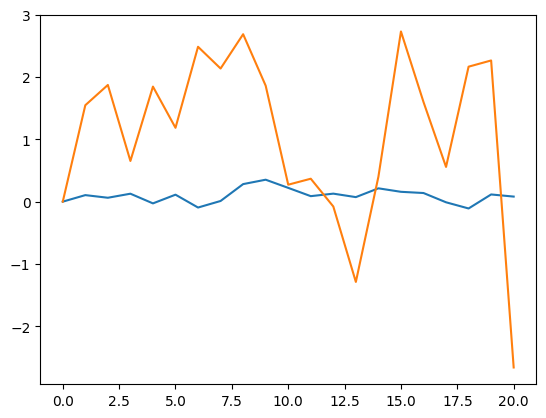

In [129]:
plt.plot(r_theta[infi_r_eps]*100)
plt.plot(r_eps[infi_r_eps]*100)

Text(0, 0.5, 'stress')

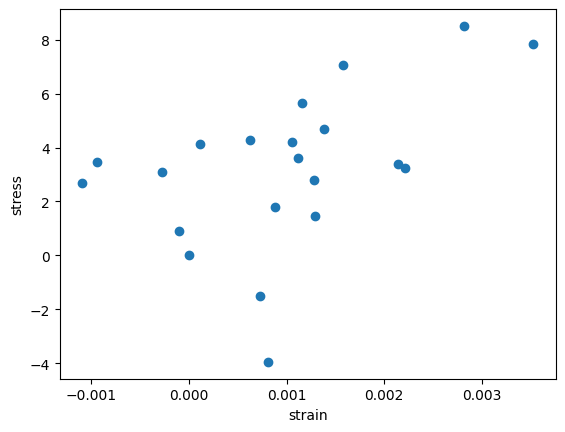

In [130]:
plt.scatter(r_theta[infi_r_eps], stress_theta)
plt.xlabel("strain")
plt.ylabel('stress')

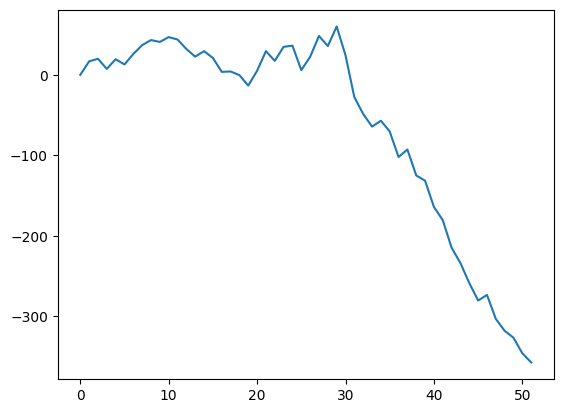

In [131]:
plt.plot(stress_r)

In [43]:
def sigma_theta(eps_r: float, eps_theta: float, E: float, nu: float) -> float:
    """
    Returns hoop (circumferential) stress σθ.
    """
    return (E * (nu*eps_r + eps_theta)) / ((1 + nu) * (1 - 2*nu))

def sigma_r(eps_r: float, eps_theta: float, E: float, nu: float) -> float:
    """
    Returns radial stress σr.
    """
    return (E * ((1 - nu)*eps_r + 2*nu*eps_theta)) / ((1 + nu) * (1 - 2*nu))

In [44]:
np.corrcoef(r_theta[msk]*100, r_eps[msk]*100)

NameError: name 'msk' is not defined

In [45]:
plt.plot(r_theta[infi_r_theta], sigma_r(r_eps[infi_r_theta], r_theta[infi_r_theta], E_mu, v))

NameError: name 'E_mu' is not defined

In [46]:
r_theta[infi_r_eps],

(array([0.00283278]),)

In [47]:
plt.plot(r_theta[msk], sigma_theta(r_eps[msk], r_theta[msk], E_mu, v))

NameError: name 'msk' is not defined

In [48]:
sample_pressures( 
        outer_radius-inner_radius,
        inner_radius, 
        R_0, 
        np.random.normal(E_mu, E_sigma,100),
        v,
        (lambda1)**2+2*(lambda2)**2-3, 
        K
      ).shape

NameError: name 'E_mu' is not defined

ValueError: x and y must be the same size

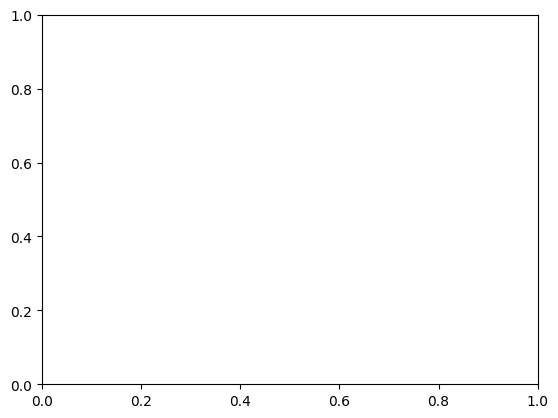

In [49]:
plt.scatter(time_v,radial_strain)
plt.scatter(time_v,circ_strain)

In [45]:
# def balloon_pressure_gent_compressible_known_thickness(
#     thickness,    # the *current* thickness, which you already know
#     radius,       # current outer radius (r)
#     radius0,      # initial radius (r0)
#     E,            # small-strain Young's modulus
#     nu,           # Poisson's ratio
#     Jm,           # Gent parameter
#     bulk_modulus=None
# )

In [50]:
import seaborn as sns

/tmp/ipykernel_8079/3439282599.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([np.random.normal(E_mu, E_sigma) for _ in range(50000)], bins=100 ,color=(255/255,140/255,0,0))


([], [])

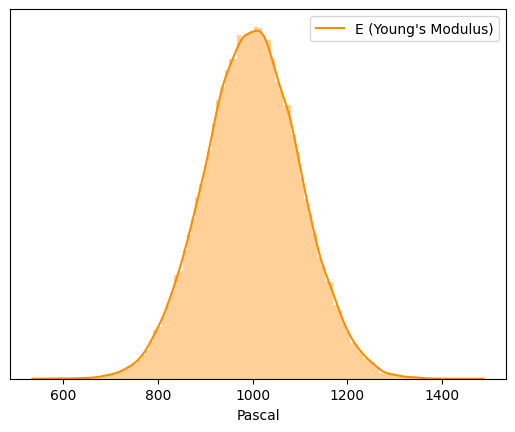

In [51]:
E_mu = 1000

E_sigma = 100

sns.distplot([np.random.normal(E_mu, E_sigma) for _ in range(50000)], bins=100 ,color=(255/255,140/255,0,0))

plt.legend(["E (Young's Modulus)"])
plt.xlabel('Pascal')
plt.ylabel('')
plt.yticks([])

In [48]:
balloon_pressure_gent( outer_radius-inner_radius, inner_radius, R_0, E, (lambda1)**2+2*(lambda2)**2)

31.493688996489496

In [49]:
J_s2 = Calculator.calculate_J(np.array(lambda1s), np.array(lambda2s), np.array(lambda3s)).tolist()

In [50]:
params = np.polyfit(x=range(len(J_s2)),y=J_s2,deg =3)

Text(0, 0.5, 'Volume (m3)')

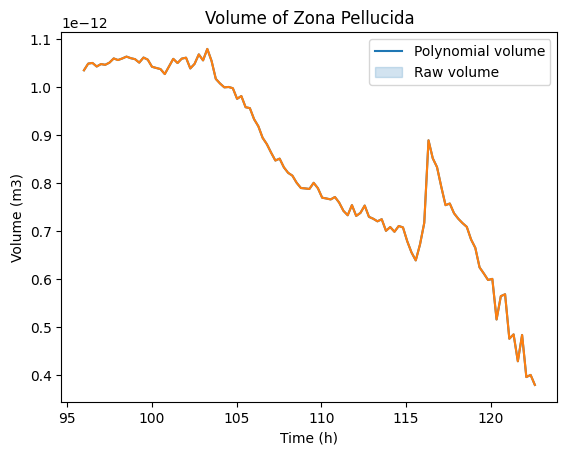

In [51]:
sns.lineplot(x=time_v+4*24, y=fitted_volumes)
sns.lineplot(x=time_v+4*24, y=raw_volumes)

plt.title('Volume of Zona Pellucida')
plt.legend(['Polynomial volume', 'Raw volume'])
plt.xlabel('Time (h)')
plt.ylabel('Volume (m3)')

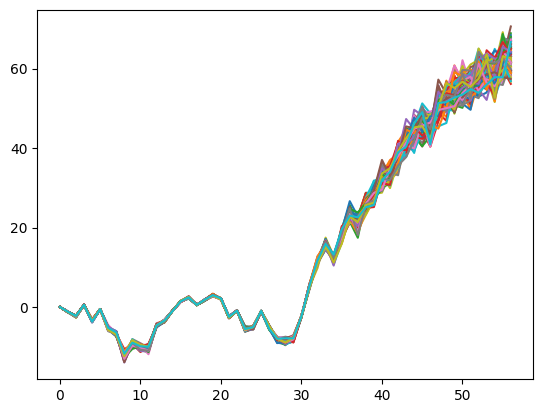

In [52]:
# plt.plot(all_sample_pressures[:65])
plt.plot(all_sample_pressures[:-50])

In [53]:
all_sample_pressures[1]

array([-1.13937743, -1.3095097 , -1.26615436, -1.2484507 , -1.21354104,
       -1.20300319, -1.33716768, -1.37275716, -1.15745298, -1.27121865,
       -1.28831848, -1.37410781, -1.24427977, -1.25748989, -1.24582775,
       -1.35450824, -1.21745502, -1.34422712, -1.21614083, -1.22446149,
       -1.16850689, -1.2355686 , -1.25859553, -1.29119066, -1.17921237,
       -1.17549867, -1.20658471, -1.35127053, -1.20881227, -1.24642138,
       -1.36914891, -1.22577756, -1.24313499, -1.28403177, -1.25036595,
       -1.20759585, -1.14532226, -1.19678732, -1.36196312, -1.22568856,
       -1.27709885, -1.2365914 , -1.25761123, -1.15719873, -1.3289844 ,
       -1.27257255, -1.18822747, -1.26579003, -1.27459146, -1.28604306,
       -1.2136529 , -1.38340168, -1.23786707, -1.27296454, -1.18164075,
       -1.27124906, -1.38655514, -1.27973113, -1.26192015, -1.2354936 ,
       -1.24176243, -1.21478048, -1.25725224, -1.27932289, -1.25985013,
       -1.32977277, -1.23695827, -1.27604019, -1.27460746, -1.21

all_sample_pressures

In [57]:
radii_strain

NameError: name 'radii_strain' is not defined

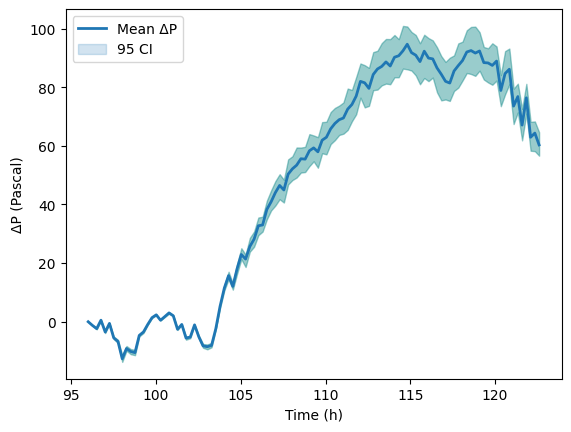

In [55]:
sns.lineplot(x=time_v+4*24, y=np.quantile(np.stack(all_sample_pressures), q=0.5,axis=1), lw=2)

plt.fill_between(time_v+4*24, np.quantile(np.stack(all_sample_pressures), q=0.025,axis=1), np.quantile(np.stack(all_sample_pressures), q=0.975,axis=1), color='teal', alpha=.4)

#sns.scatterplot(x =df_sat_test['t'], y = np.array(test_ppc.observed_data.obs), label = 'True Value')
plt.legend(['Mean ΔΡ', '95 CI'])
plt.xlabel('Time (h)')
plt.ylabel('ΔΡ (Pascal)')
plt.show()

Text(0, 0.5, 'ΔΡ (Pascal)')

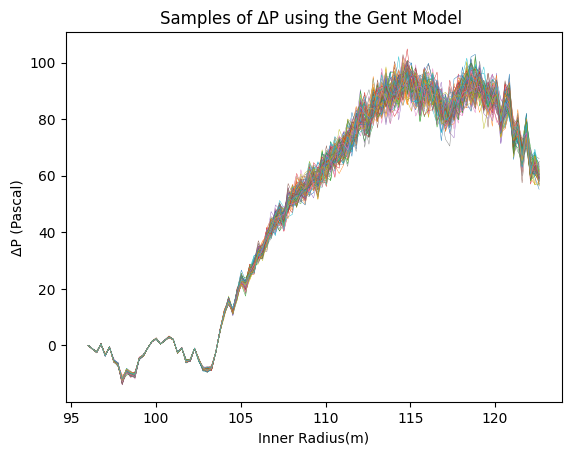

In [56]:
for i in range(100):
    sns.lineplot(x=time_v+4*24, y=np.stack(all_sample_pressures)[:,i], lw=0.3)

plt.title('Samples of ΔΡ using the Gent Model ')
plt.xlabel('Inner Radius(m)')
plt.ylabel('ΔΡ (Pascal)')


In [448]:
import numpy as np

def gent_strain_energy_compressible(
    lam1, lam2, lam3,    # principal stretches
    E,                   # Young's modulus
    nu,                  # Poisson's ratio
    Jm,                  # Gent parameter
    bulk_modulus=None    # K (if None, estimate from E, nu)
):
    """
    Calculate the compressible Gent strain-energy density W per unit reference volume:

    W = W_dev + W_vol

    with:
      W_dev = -(mu * Jm / 2) * ln[ 1 - (I1_bar - 3) / Jm ],
      W_vol = 0.5 * K * (J - 1)^2,

    where:
      mu = E / [2(1 + nu)],
      K  = bulk_modulus (passed or estimated by E / [3(1 - 2 nu)]),
      J  = lam1 * lam2 * lam3,
      I1_bar = (lam1^2 + lam2^2 + lam3^2) * J^(-2/3).

    Returns
    -------
    W : float
        Strain-energy density (same unit system as E, etc.).
    """

    # Shear modulus
    mu = E / (2.0 * (1.0 + nu))

    # Bulk modulus
    if bulk_modulus is None:
        bulk_modulus = E / (3.0 * (1.0 - 2.0 * nu))

    # Compute volumetric ratio
    J = lam1 * lam2 * lam3

    # Compute deviatoric (bar) stretches
    J_neg2over3 = J ** (-2.0 / 3.0)
    I1_bar = (lam1**2 + lam2**2 + lam3**2) * J_neg2over3

    # Check Gent limiting stretch
    if (1.0 - (I1_bar - 3.0) / Jm) <= 0.0:
        return float('inf')

    # Deviatoric part
    W_dev = -0.5 * mu * Jm * np.log(1.0 - (I1_bar - 3.0)/Jm)

    # Volumetric part
    W_vol = 0.5 * bulk_modulus * (J - 1.0)**2

    # Total strain-energy density
    return W_dev + W_vol


# -------------------------------
# Example usage:
# -------------------------------
if __name__ == "__main__":

    # Example parameters
    lam1, lam2, lam3 = 1.2, 1.2, 0.9  # some stretches
    E = 1e6                           # Young's modulus
    nu = 0.3                          # Poisson's ratio
    Jm = 80.0                         # Gent parameter

    W = gent_strain_energy_compressible(lam1, lam2, lam3, E, nu, Jm)
    print(f"Compressible Gent strain-energy density = {W:.4f}")


Compressible Gent strain-energy density = 56567.3707


In [449]:
# Compute strain using ε = (r - r0) / r0
mean_DP = np.stack(all_sample_pressures).mean(axis=1)

DP_q1 = mean_DP-2*np.stack(all_sample_pressures).std(axis=1)
DP_q2 = mean_DP+2*np.stack(all_sample_pressures).std(axis=1)
t_thin = fitted_outer- fitted_inner


strain_values = (fitted_inner - R_0) / R_0
# Compute stress using σ = (P * r) / (2 * t)
stress_values_mean = (mean_DP * fitted_inner) / (2 * t_thin)

stress_values_q2 = (DP_q2 * fitted_inner) / (2 * t_thin)
stress_values_q1 = (DP_q1 * fitted_inner) / (2 * t_thin)

# Approximate strain energy density by numerical integration W = ∫ σ dε
W_approx = np.cumsum(stress_values_mean * np.gradient(strain_values))  # Numerical integration
W_approx_q1 = np.cumsum(stress_values_q1 * np.gradient(strain_values))  # Numerical integration
W_approx_q2 = np.cumsum(stress_values_q2 * np.gradient(strain_values))

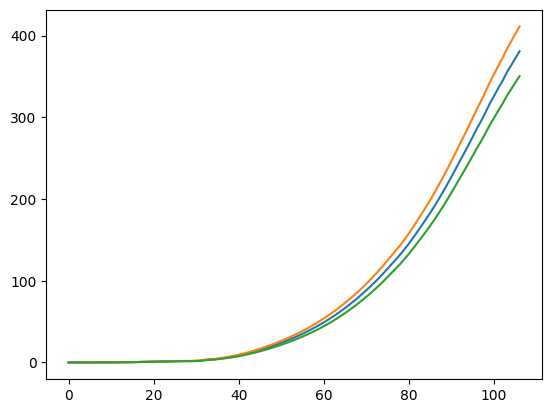

In [450]:
plt.plot(W_approx)
plt.plot(W_approx_q2)
plt.plot(W_approx_q1)

In [451]:
def pressure_simulation_linear(n_embryos: float)-> float:

    slope = 3.52
    intercept =  30

    return n_embryos*slope + intercept


In [452]:
def simulate_pressure_per_cell_per(n_cells: int):
    #  cell contributes to an osmotic pressure increase of ~50–100 Pa per hour
    avg_pressure_contrib = 6
    std_pressure_contrib = 1

    return n_cells* np.normal(avg_pressure_contrib, std_pressure_contrib)

In [453]:
sample_pth

PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

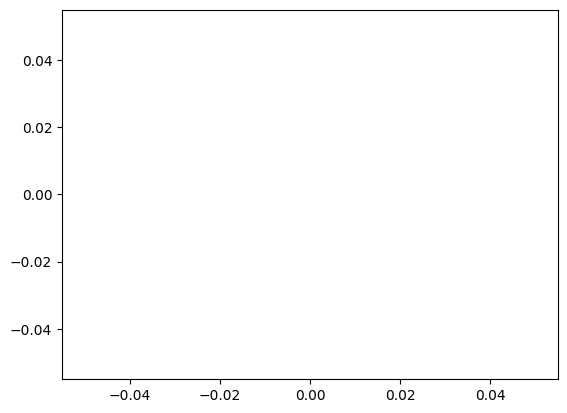

In [454]:
plt.plot(np.array(volumes))

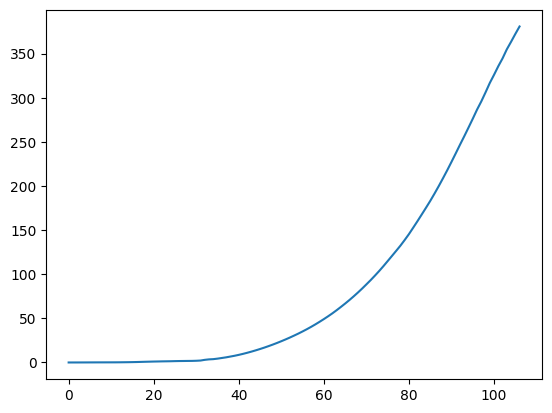

In [455]:
plt.plot(W_approx)

In [456]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize

# # Given external pressure (estimated, adjust if needed)
# P_ext = 1000  # Arbitrary units, adjust based on experiment
# W_proxy = np.sum(W_approx)  # Work = P_ext * ΔV

# # Ogden strain energy function (single-term, compressible)
# def ogden_energy(params, lambda1s, lambda2s, lambda3s, Js):
#     mu1, alpha1, kappa = params
#     W = (mu1 / alpha1) * (lambda1s ** alpha1 + lambda2s ** alpha1 + lambda3s ** alpha1 - 3) \
#         + (1/kappa) * (Js - 1) ** 2
#     return W

# # Objective function
# def objective(params, lambda1s, lambda2s, lambda3s, Js, W_proxy):
#     predicted_energy = ogden_energy(params, lambda1s, lambda2s, lambda3s, Js)
#     residuals = np.sum(predicted_energy) - W_proxy
#     return np.sum(residuals ** 2)

# # Parameter bounds and initial guess
# bounds = [(-1000, 50000),    # mu1
#           (0.001, 30),    # alpha1
#           (1e-4, 1e7)]  # kappa

# initial_guess = [-1e-3, 0.5, 1e3]

# # Minimize
# result = minimize(
#     objective,
#     x0=initial_guess,
#     args=(np.array(lambda1s), np.array(lambda2s), np.array(lambda3s), np.array(J_s), W_proxy),
#     method='L-BFGS-B',
#     bounds=bounds
# )

# mu1_fitted, alpha1_fitted, kappa_fitted = result.x
# print(f"Fitted Parameters: mu1={mu1_fitted}, alpha1={alpha1_fitted}, kappa={kappa_fitted}")

# # Compute residuals and plot
# predicted_energy = ogden_energy(result.x, np.array(lambda1s), np.array(lambda2s),
#                          np.array(lambda3s), np.array(J_s))

# residuals =  predicted_energy- W_proxy
# plt.figure(figsize=(8, 5))
# plt.plot(residuals, marker="o", label="Residuals")
# plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
# plt.xlabel("Frame")
# plt.ylabel("Residual Error")
# plt.title("Ogden Model Fitting Residuals (Fluid Work Proxy)")
# plt.legend()
# plt.show()

# # Decision on higher-order Ogden model
# if np.max(np.abs(residuals)) > 0.1:
#     print("Residuals are large. A higher-order Ogden model may be needed.")
# else:
#     print("Single-term Ogden model is sufficient.")


In [483]:
plt.plot(predicted_energy)sampl

SyntaxError: invalid syntax (1158414851.py, line 1)

In [484]:
sample_pth

PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

In [458]:
def ogden_energy(params, lambda1s, lambda2s, lambda3s, Js):
    mu1, alpha1, kappa = params
    W = (mu1 / alpha1) * (lambda1s ** alpha1 + lambda2s ** alpha1 + lambda3s ** alpha1 - 3) \
        + (1/kappa) * (Js - 1) ** 2
    return W

sample_idx = np.random.choice(len(lambda1s), 10, replace=False) 
J = np.array(J_s)[sample_idx] 
l1 =  np.array(lambda1s)[sample_idx]#*(J**(-1/3))
l2 = np.array(lambda2s)[sample_idx]#*(J**(-1/3))
l3 = np.array(lambda3s)[sample_idx]#*(J**(-1/3))


In [459]:
np.array(lambda2s) - np.array(lambda3s)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [460]:
class OdgenFitter:

    @staticmethod
    def ogden_energy_term(l1: np.ndarray, l2: np.ndarray, l3: np.ndarray, mu: float, alpha: float) -> np.ndarray:
        return mu*(l1**alpha+l2**alpha+l3**alpha-3)/alpha


    @staticmethod
    def total_odgen_energy(mu, alpha, kappa , l1, l2, l3, J) -> np.ndarray:
        # mu, alpha, kappa  = params
        term1 = OdgenFitter.ogden_energy_term(l1,l2,l3, mu,alpha)

        return term1 + (1/kappa)*(J-1)**2

In [461]:
W_proxy-W_proxy1

array([-6.02561268e-02, -6.14657297e+01, -3.93977067e+01, -2.54444524e+01,
       -1.29475331e+02, -1.06263705e+01, -1.22556735e+01, -1.82401238e+00,
       -5.35900081e-02, -6.34950499e-01])

Fitted Parameters: [1.09554903e+03 7.50354335e-01 4.20376407e-03]
Fitted Parameters: [1.09554903e+03 7.50354335e-01 4.20376407e-03]


/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


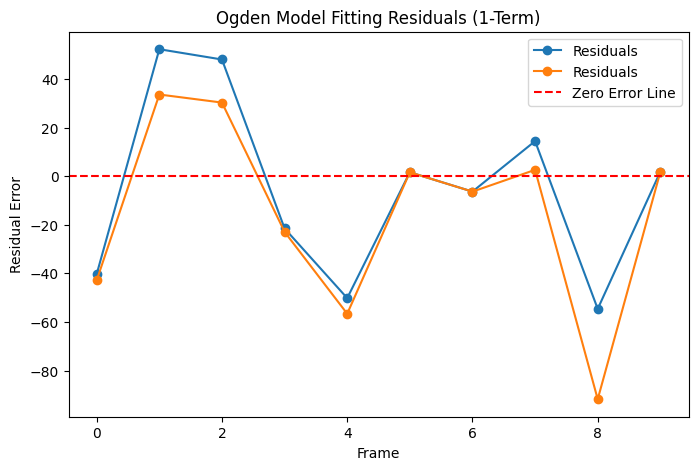

In [462]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from copy import copy
# Given external pressure (estimated, adjust if needed)
# Compute work done to displace fluid as a proxy for strain energy
W_proxy1 = W_approx_q2[sample_idx]  # Work = P_ext * ΔV
W_proxy = W_approx_q1[sample_idx] 

# Objective function: minimizing error in strain energy fit
def objective(params, lambda1s, lambda2s, lambda3s, Js, W_proxy, num_terms=2):
    """
    Computes residual error between experimental work-proxy and model-predicted strain energy.
    """
    mu, alpha, kappa  = params
    predicted_energy = OdgenFitter.total_odgen_energy(mu, alpha, kappa, lambda1s, lambda2s, lambda3s, Js)
    residuals = predicted_energy - W_proxy  # Fit to fluid displacement work

    shear_err = G-mu*alpha/2
    bulk_err = K-2/kappa
    return np.sum(residuals**2) +bulk_err**2+shear_err**2# Sum of squared errors

# Define number of Ogden terms (increase if needed)
num_terms = 1  # Change to 3+ if necessary

# Define parameter bounds: ensuring reasonable values
bounds = [(-500, 5000),    # mu1
          (-300.5, 300),    # alpha1
          (1e-5, 1e2)]  # kappa

initial_guess = [-1e-3, 0.5, 1e3]


# Run differential evolution optimization
result = differential_evolution(objective, bounds, 
                                args=(l1,l2,l3,J, W_proxy, num_terms), tol=1e-6)

# Extract fitted parameters
fitted_params = result.x
print(f"Fitted Parameters: {fitted_params}")
mu, alpha, kappa  = fitted_params
# Compute residuals
residuals = OdgenFitter.total_odgen_energy(mu, alpha, kappa,l1,l2,l3,J) - W_proxy

####
result1 = differential_evolution(copy(objective), copy(bounds), 
                                args=copy((l1,l2,l3,J, W_proxy1, num_terms)), tol=1e-6)

# Extract fitted parameters

print(f"Fitted Parameters: {fitted_params}")
mu1, alpha1, kappa1  = result1.x
# Compute residuals
residuals2 = OdgenFitter.total_odgen_energy(mu, alpha, kappa,l1,l2,l3,J) - W_proxy1

# Plot residuals
plt.figure(figsize=(8, 5))
plt.plot(residuals, marker="o", label="Residuals")
plt.plot(residuals2, marker="o", label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Frame")
plt.ylabel("Residual Error")
plt.title(f"Ogden Model Fitting Residuals ({num_terms}-Term)")
plt.legend()
plt.show()


In [463]:
import numpy as np

def ogden_first_order_stress(lam1, lam2, lam3,J, mu, alpha, kappa ):


    sigma_vol = kappa * np.log(J)
 

    factor = mu*J**(-alpha/3)

    t1 = factor*(lam1**alpha-(lam1**alpha+lam2**alpha+lam3**alpha)/3) + sigma_vol
    sigma1 = t1/J

    t2 = factor*(lam2**alpha-(lam1**alpha+lam2**alpha+lam3**alpha)/3) + sigma_vol
    sigma2 = t2/J

    t3 = factor*(lam3**alpha-(lam1**alpha+lam2**alpha+lam3**alpha)/3) + sigma_vol
    sigma3 = t3/J


    return sigma1, sigma2, sigma3


In [464]:
def stress(mu,l,alpha):
    return 2*mu*(l**alpha-l**(-alpha/2))/alpha

In [465]:
result.x

array([1.09554903e+03, 7.50354335e-01, 4.20376407e-03])

In [466]:
result1.x

array([9.81282437e+02, 8.48516846e-01, 4.20349326e-03])

In [467]:
sigma1, sigma2, sigma3 = ogden_first_order_stress(np.array(lambda1s),np.array(lambda2s), np.array(lambda3s), np.array(J_s), *result.x)

sigma1_1, sigma2_1, sigma3_1 = ogden_first_order_stress(np.array(lambda1s),np.array(lambda2s), np.array(lambda3s), np.array(J_s), *result1.x)

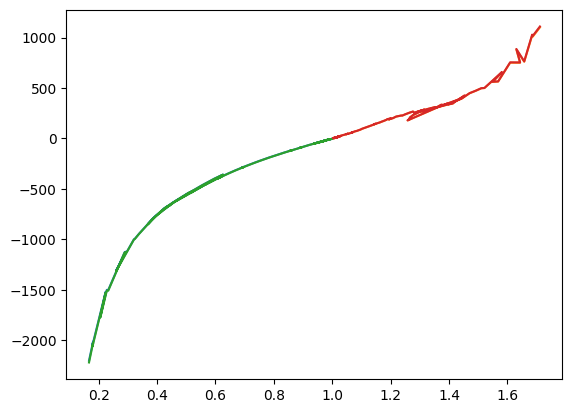

In [471]:
plt.plot(np.array(lambda1s), sigma1)
plt.plot(np.array(lambda3s), sigma3)

plt.plot(np.array(lambda1s), sigma1_1)
plt.plot(np.array(lambda3s), sigma3_1)



In [472]:


t0 = fitted_outer[0]-fitted_inner[0]
r0 =  fitted_inner[0]

In [479]:
sort_idx = np.argsort(thick_strain)

In [480]:

radii_strain = (fitted_inner-r0)/r0

In [481]:


thick_strain = ((fitted_outer-fitted_inner)-t0)/t0

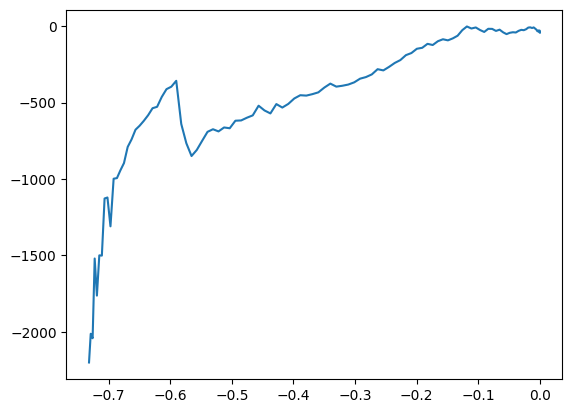

In [482]:

plt.plot(thick_strain[sort_idx], sigma1[sort_idx])

# plt.plot(radii_strain, sigma3_1)


In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Ogden model function (single-term, compressible)
def ogden_model(params, lambda1s, lambda2s, Js):
    """
    Computes the stress from the Ogden model given deformation data.
    
    params: [mu1, alpha1, kappa] (single-term Ogden model)
    lambda1s, lambda2s, Js: arrays of experimental stretch ratios
    """
    mu1, alpha1, kappa = params
    sigma_theta = mu1 * (lambda2s ** (alpha1 - 1)) - kappa * (Js - 1)
    return sigma_theta

import numpy as np

def ogden_model(params, lambda1s, lambda2s, lambda3s, Js):
    """
    Computes the strain energy density W from the Ogden foam model.

    params: [mu1, alpha1, beta1] (single-term Ogden model)
    lambda1s, lambda2s, lambda3s: principal stretches (arrays)
    Js: Determinant of the deformation gradient (volume change ratio)
    """
    mu1, alpha1, beta1 = params

    # Strain energy density W (corrected)
    W = (mu1 / alpha1) * ((Js ** (alpha1 / 3)) * (lambda1s**alpha1 + lambda2s**alpha1 + lambda3s**alpha1) - 3) \
        + mu1 * (Js ** (-alpha1 * beta1) - 1)

    return W

def ogden_model2(params, lambda1s, lambda2s, lambda3s, Js):
    """
    Computes the stress from a 2-term Ogden model given deformation data.
    
    params: [mu1, alpha1, beta1, mu2, alpha2, beta2]
    lambda1s, lambda2s, lambda3s, Js: arrays of experimental stretch ratios (and the volumetric term).
    
    Returns:
        The total stress contribution from both Ogden terms.
    """
    mu1, alpha1, beta1, mu2, alpha2, beta2 = params

    # Term 1
    term1 = mu1 * (
        (Js ** (alpha1 / 3.0)) * (lambda1s ** alpha1 + lambda2s ** alpha1 + lambda3s ** alpha1) - 3
    ) / alpha1 + mu1 * (Js ** (-alpha1 * beta1) - 1)

    # Term 2
    term2 = mu2 * (
        (Js ** (alpha2 / 3.0)) * (lambda1s ** alpha2 + lambda2s ** alpha2 + lambda3s ** alpha2) - 3
    ) / alpha2 + mu2 * (Js ** (-alpha2 * beta2) - 1)

    return term1 + term2

# Objective function: minimizing deformation error
def objective(params, lambda1s, lambda2s,lambda3s, Js, target_deformations):
    """
    Computes residual error between experimental and model-predicted stretches.
    """
    predicted_stretch = ogden_model(params, lambda1s, lambda2s,lambda3s, Js)
    residuals = predicted_stretch - target_deformations  # Deformation-based fitting
    return np.sum(residuals**2)  # Sum of squared errors

# Define parameter bounds: ensuring reasonable values
bounds = [(0.01, 30000),  # mu1: shear modulus
          (1, 10),      # alpha1: nonlinearity
          (0.00001, 2
          )] # kappa: bulk modulus

# Run differential evolution
result = differential_evolution(objective, bounds, args=(np.array(lambda1s), np.array(lambda2s), np.array(lambda3s),np.array(J_s), W_approx), strategy='best1bin', tol=1e-6)

# Extract fitted parameters
mu1_fitted, alpha1_fitted, kappa_fitted = result.x

# Display fitted parameters
mu1_fitted, alpha1_fitted, kappa_fitted


(np.float64(211.00809997868666),
 np.float64(2.3328032581328326),
 np.float64(0.23803984694434147))

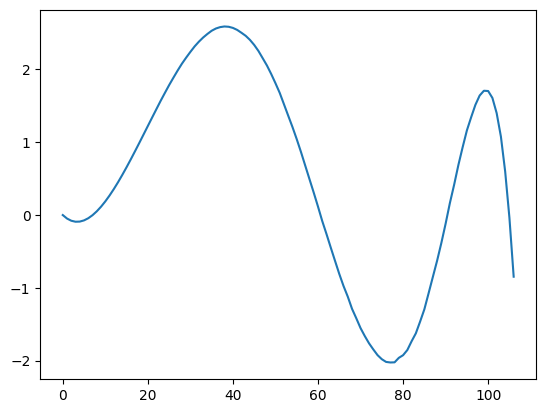

In [141]:
plt.plot(W_approx-ogden_model(result.x,np.array(lambda1s), np.array(lambda2s), np.array(lambda3s),np.array(J_s)))

In [142]:
def ogden_model(params, lambda1s, lambda2s,lambda3s, Js):
    """
    Computes the stress from the Ogden model given deformation data.
    
    params: [mu1, alpha1, kappa] (single-term Ogden model)
    lambda1s, lambda2s, Js: arrays of experimental stretch ratios
    """
    mu1, alpha1, beta1 = params
    # sigma_theta = mu1 * (lambda2s ** (alpha1 - 1)) - kappa * (Js - 1)

    
    return mu1*((Js**(alpha1/3))*(lambda1s**alpha1+ lambda2s**alpha1+lambda3s**alpha1)-3)/alpha1 + mu1*(J**(-alpha1*beta1)-1)

In [143]:
import numpy as np

def ogden_stress(params, lambda1s, lambda2s, lambda3s):
    """
    Compute principal Cauchy stresses for single-term Ogden (compressible).
    params = [mu, alpha, kappa]
    lambda1s, lambda2s, lambda3s = arrays of principal stretches
    """
    mu, alpha, kappa = params
    # Jacobian (volume change)
    J = lambda1s * lambda2s * lambda3s
    
    # Principal Cauchy stress for each direction
    # sigma_i = (lambda_i / J) * dW/d(lambda_i)
    # For single-term Ogden + volumetric penalty:
    #   sigma_i = (mu * lambda_i^alpha / J) + kappa * (J - 1)
    
    sigma1 = mu * (lambda1s**alpha) / J + kappa * (J - 1)
    sigma2 = mu * (lambda2s**alpha) / J + kappa * (J - 1)
    sigma3 = mu * (lambda3s**alpha) / J + kappa * (J - 1)
    
    return sigma1, sigma2, sigma3


In [144]:
result.x

array([211.00809998,   2.33280326,   0.23803985])

In [145]:
sigma1, sigma2, sigma3 = ogden_stress(result.x,np.array(lambda1s), np.array(lambda2s), np.array(lambda3s))
# plt.plot( np.array(lambda3s))

In [146]:
sigma3

array([211.00809998, 211.04505268, 211.16290697, 211.36056566,
       211.63708104, 211.99164763, 212.42359579, 212.93238583,
       213.51760299, 214.1789528 , 214.9162571 , 215.72945052,
       216.61857737, 217.58378907, 218.62534182, 219.74359474,
       220.93900836, 222.21214333, 223.56365955, 224.99431552,
       226.50496795, 228.09657167, 229.77017974, 231.52694381,
       233.36811471, 235.29504321, 237.30918103, 239.412082  ,
       241.60540342, 243.89090759, 246.2704635 , 248.74604869,
       251.31975122, 253.99377185, 256.77042622, 259.65214729,
       262.64148777, 265.74112269, 268.95385198, 272.28260322,
       275.73043429, 279.30053606, 282.99623516, 286.82099652,
       290.77842598, 294.8722727 , 299.10643141, 303.48494443,
       308.01200342, 312.69195079, 317.52928066, 322.52863931,
       327.69482508, 333.0327875 , 338.54762559, 344.24458523,
       350.12905534, 356.20656285, 362.48276608, 368.9634465 ,
       375.65449849, 382.56191691, 389.69178221, 397.05

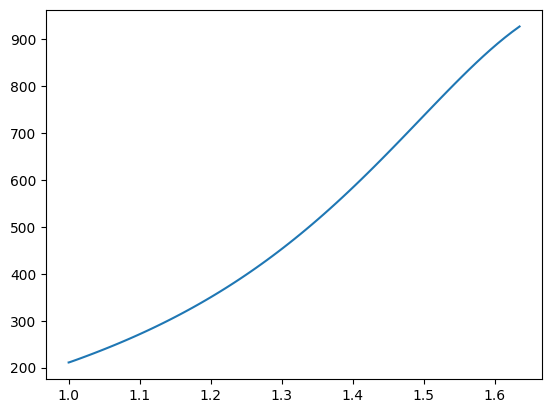

In [147]:
# plt.plot(lambda1s, sigma1 )
plt.plot(lambda3s, sigma3 )

In [148]:
residuals = ogden_model(result.x,np.array(lambda1s), np.array(lambda2s), np.array(J_s)) - np.array(lambda2s)

# Plot residuals
plt.figure(figsize=(8, 5))
plt.plot(residuals, marker="o", label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("Frame")
plt.ylabel("Residual Error")
plt.title("Ogden Model Fitting Residuals")
plt.legend()
plt.show()

# Decision on higher-order Ogden model
if np.max(np.abs(residuals)) > 0.1:  # If residuals are large, move to 2-term Ogden
    print("Residuals are large. A higher-order Ogden model may be needed.")
else:
    print("Single-term Ogden model is sufficient.")

TypeError: ogden_model() missing 1 required positional argument: 'Js'

In [149]:
import numpy as np
from scipy.optimize import least_squares

# Ogden model function
def ogden_model(params, lambda1s, lambda2s, Js):
    """
    Computes the stress from the Ogden model given deformation data.
    
    params: [mu1, alpha1, kappa] (single-term Ogden model)
    lambda1s, lambda2s, Js: arrays of experimental stretch ratios
    """
    mu1, alpha1, kappa = params
    sigma_theta = mu1 * (lambda2s ** (alpha1 - 1)) - kappa * (Js - 1)
    return sigma_theta

# Objective function: minimizing deformation error
def objective(params, lambda1s, lambda2s, Js, target_deformations):
    """
    Computes residual error between experimental and model-predicted stretches.
    """
    predicted_stretch = ogden_model(params, lambda1s, lambda2s, Js)
    residuals = predicted_stretch - target_deformations  # Deformation-based fitting
    return residuals

# Initial guess for material parameters
initial_guess = [0.5, 3.0, 1]  # [mu1, alpha1, kappa]

# Use least squares fitting
result = least_squares(objective, initial_guess, args=(np.array(lambda1s), np.array(lambda2s), np.array(J_s), np.array(lambda2s)))

# Extract fitted parameters
mu1_fitted, alpha1_fitted, kappa_fitted = result.x
print(f"Fitted Parameters: mu1={mu1_fitted}, alpha1={alpha1_fitted}, kappa={kappa_fitted}")


Fitted Parameters: mu1=1.0, alpha1=2.0000000000000004, kappa=-1.0288735700892697e-15


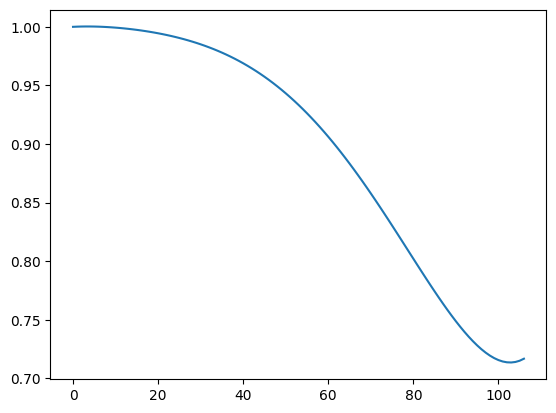

In [100]:
# plt.plot(lambda3s)
# plt.plot(lambda1s)
plt.plot(J_s)

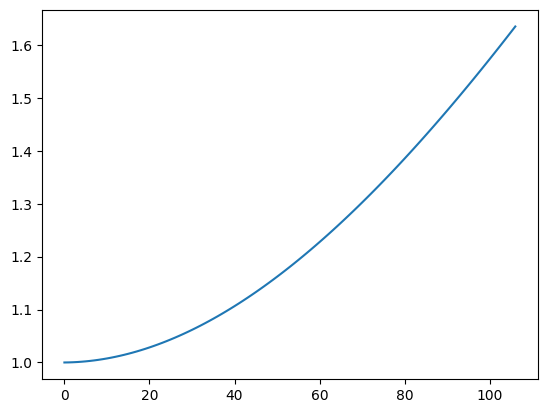

In [101]:
plt.plot(lambda2s)

In [102]:
sample_pth

PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

In [103]:
fitted_results[i]

FittedMaskResults(inner_radius=78.06365316518865, mean_thickess=0.9006052514304075, thickness_std=0.2887256022346782, outer_radius=80.99157028273501, circle_center=(106.93612531578715, 115.96435636233578), area=19402.0, nframe=106)

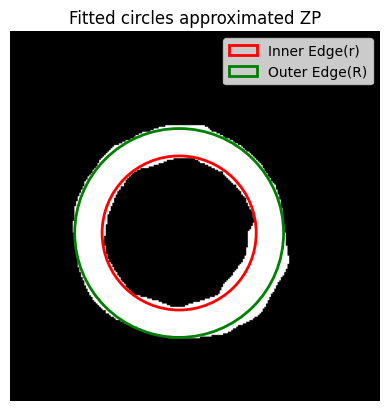

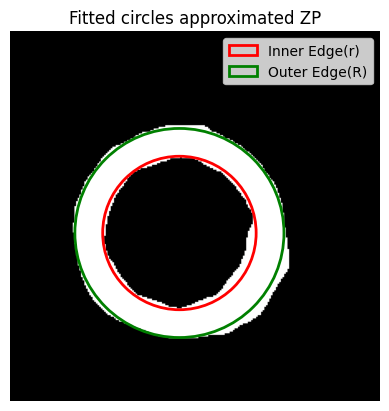

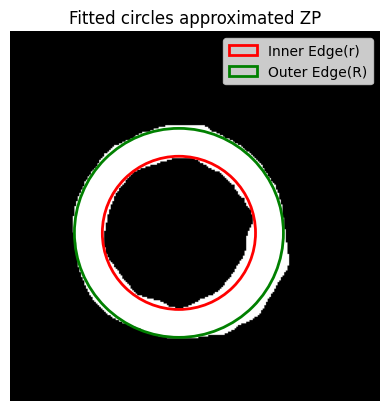

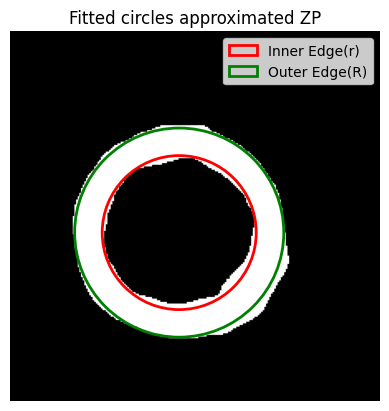

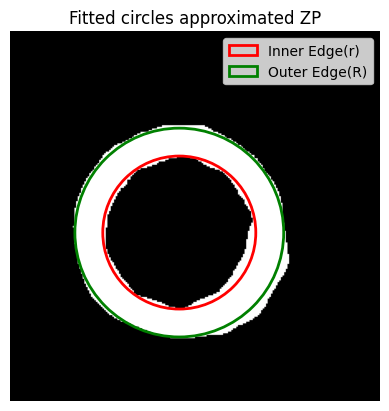

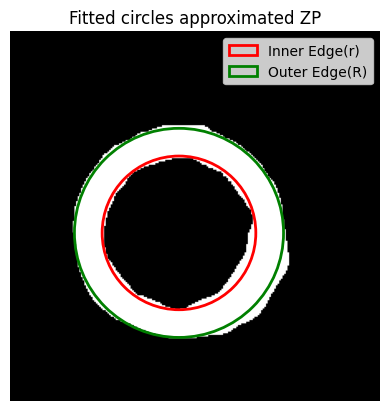

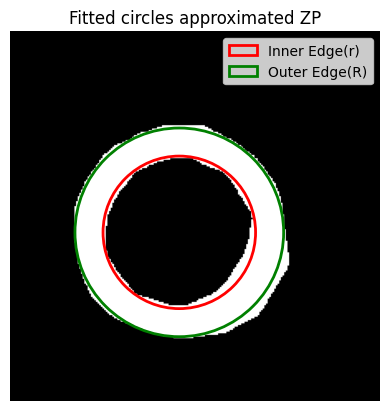

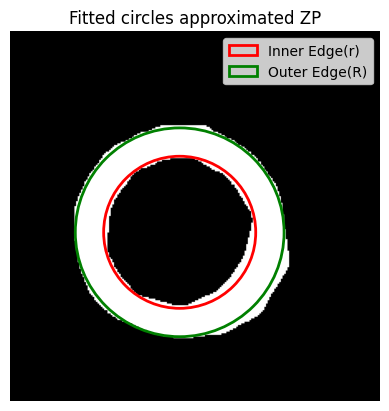

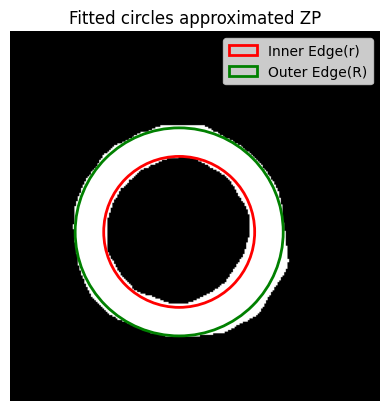

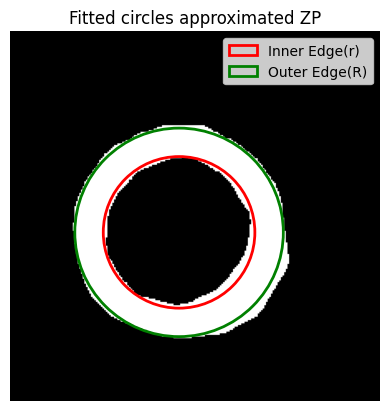

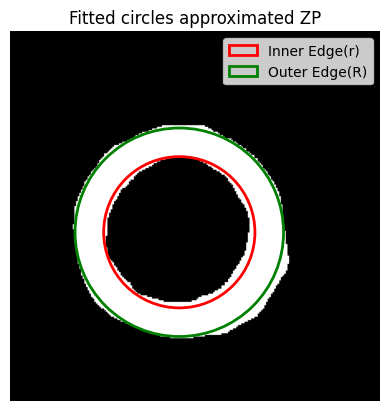

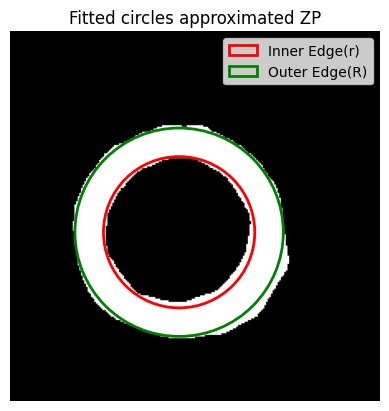

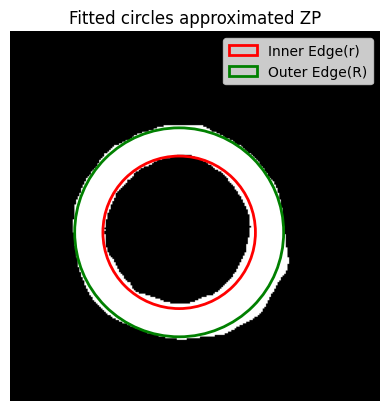

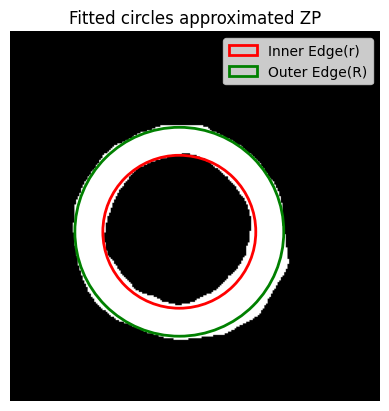

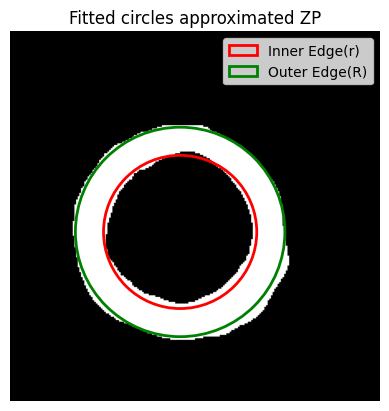

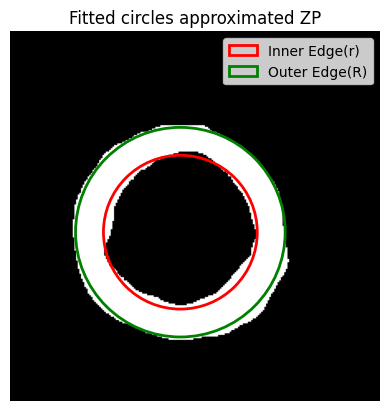

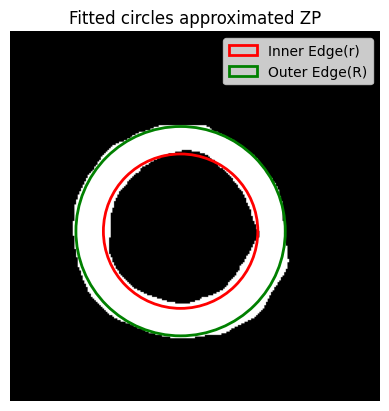

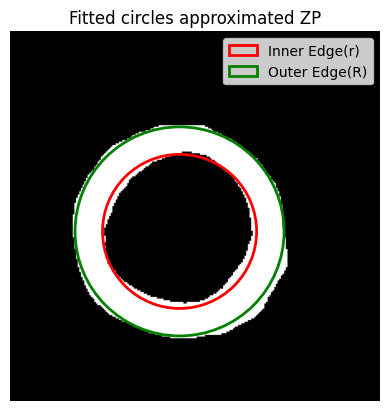

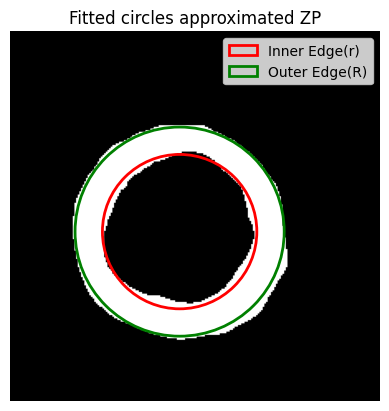

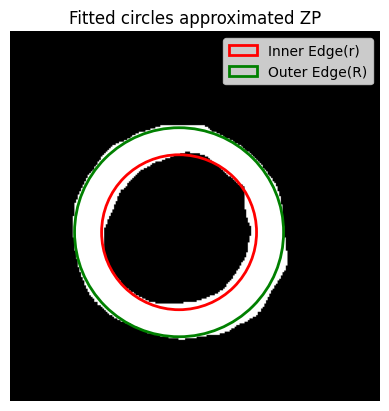

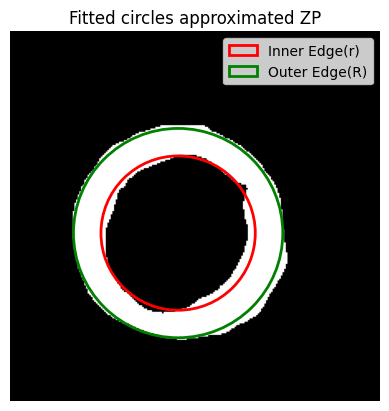

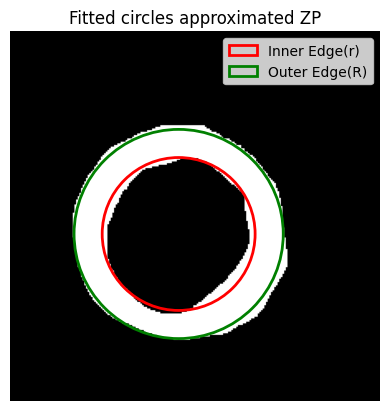

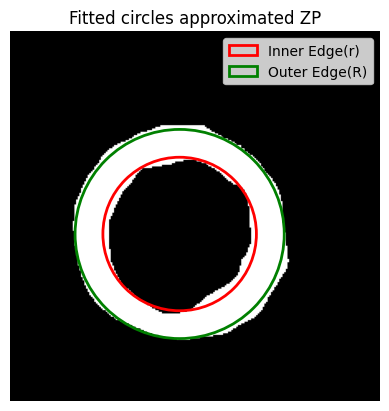

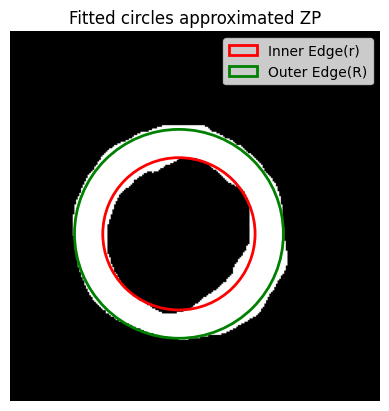

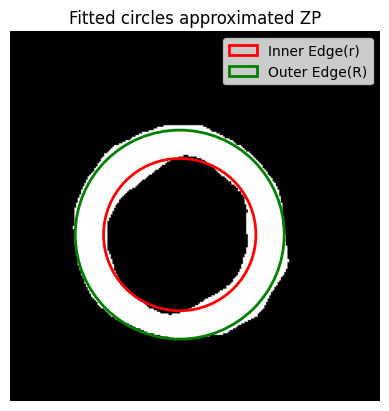

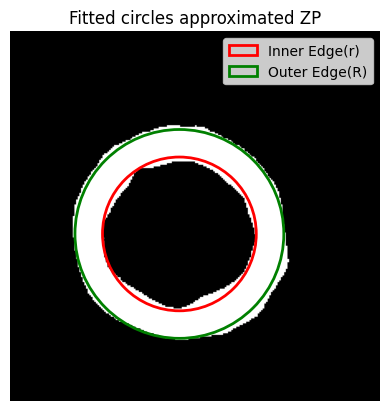

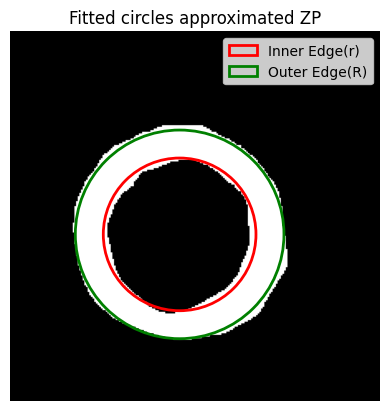

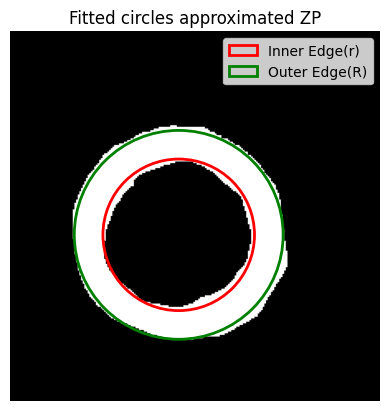

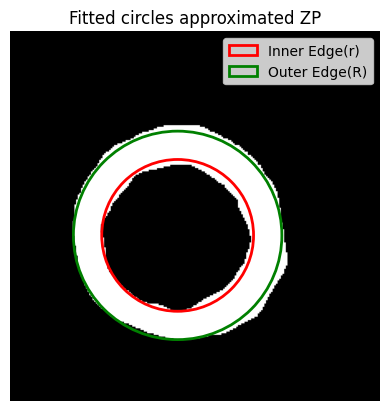

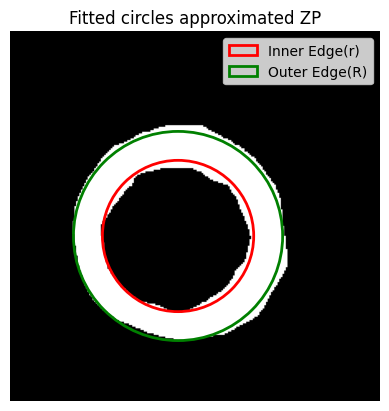

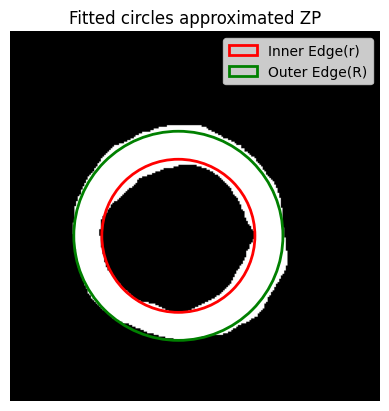

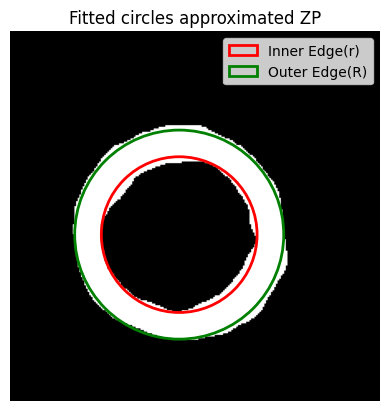

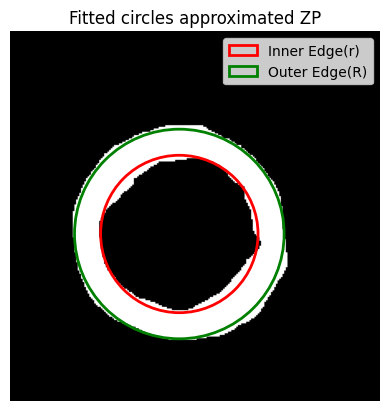

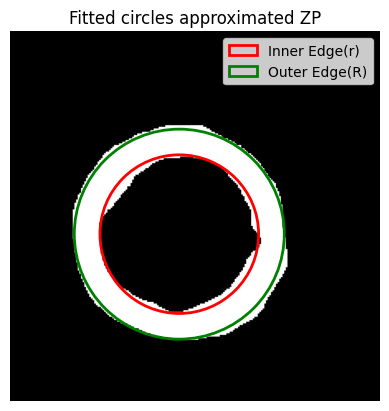

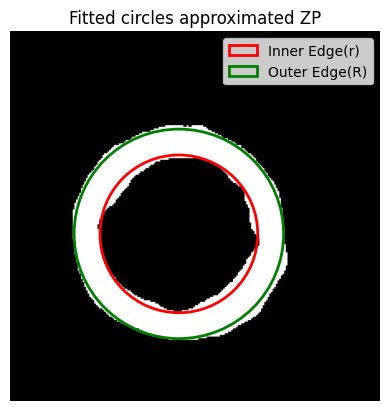

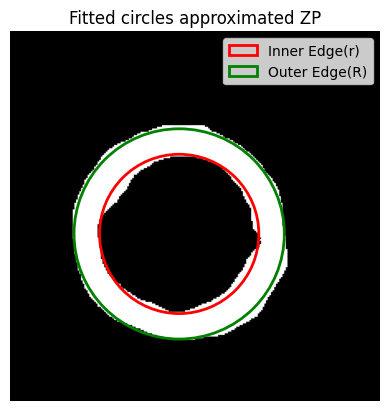

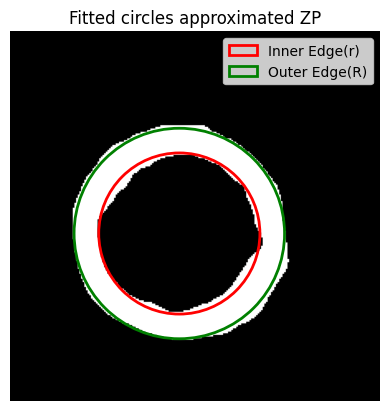

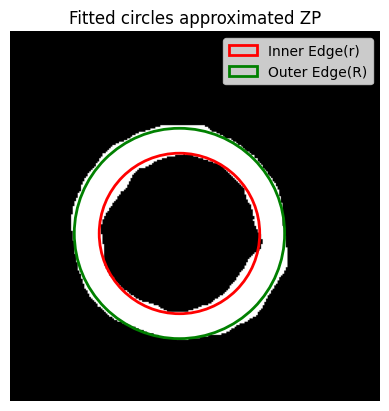

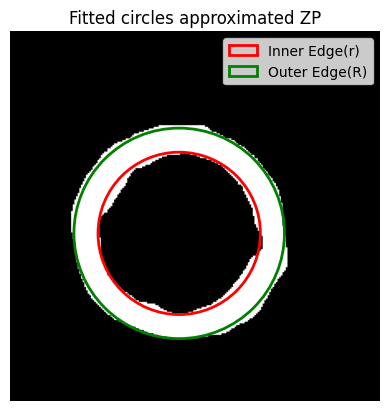

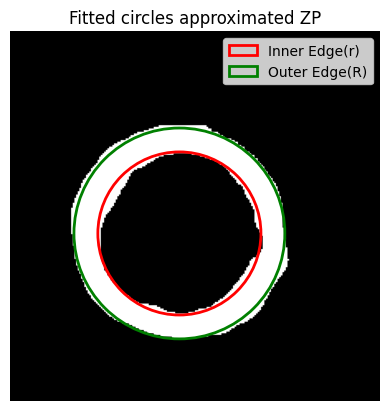

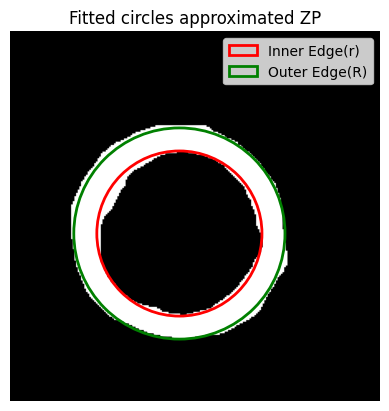

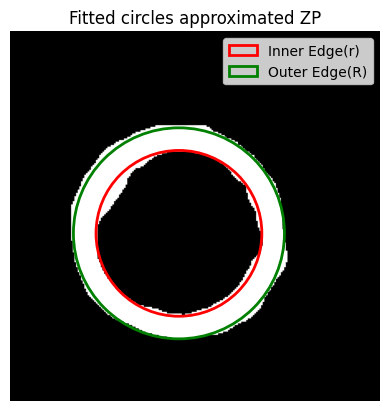

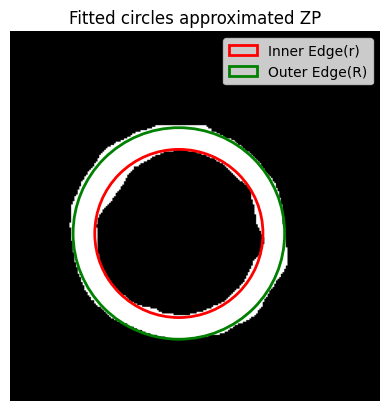

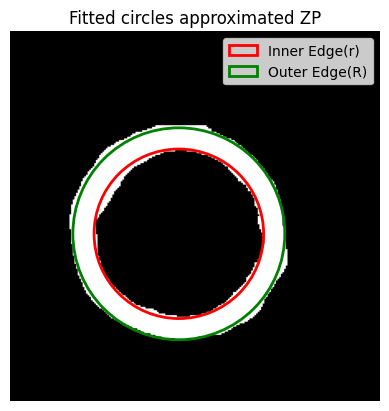

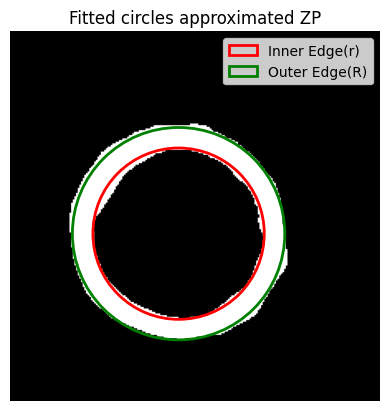

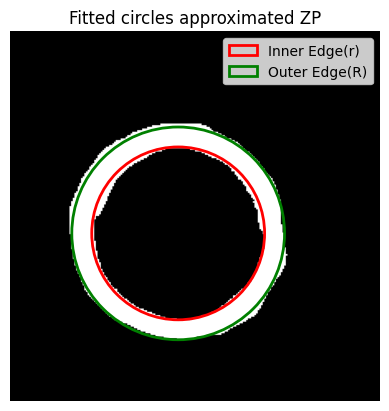

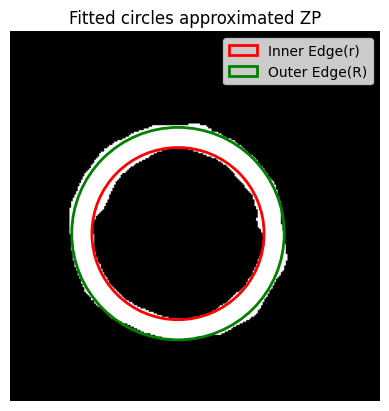

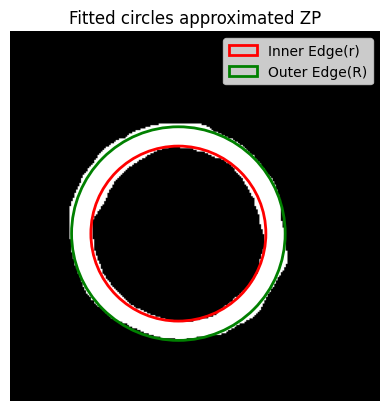

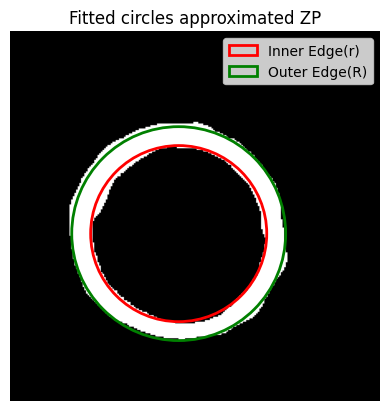

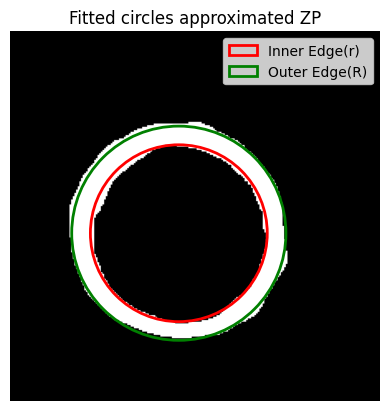

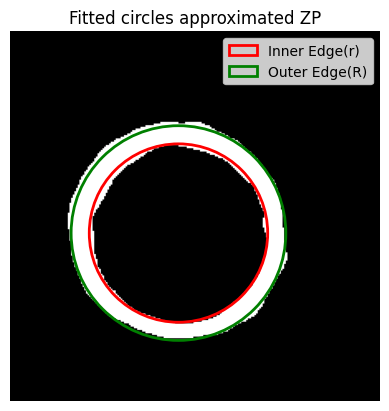

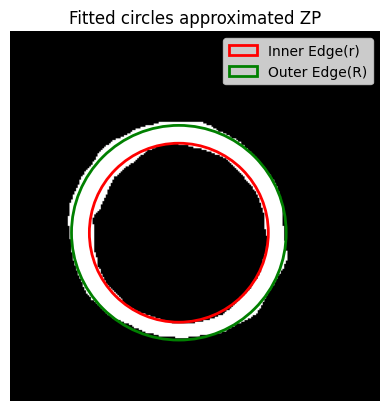

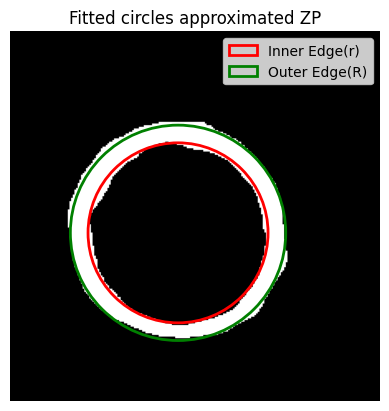

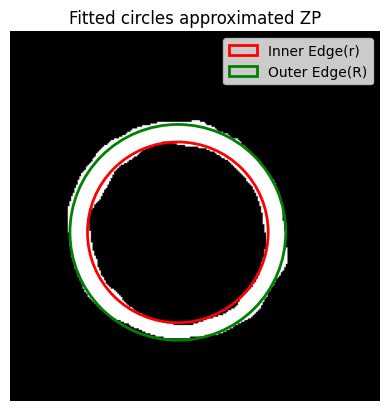

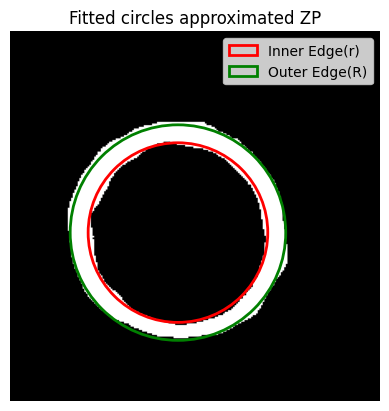

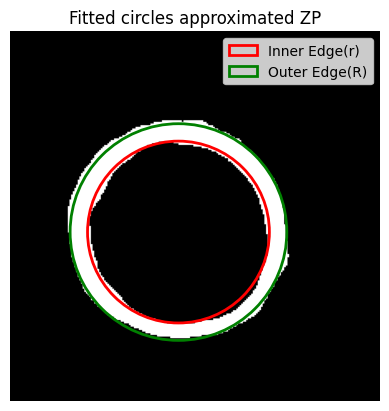

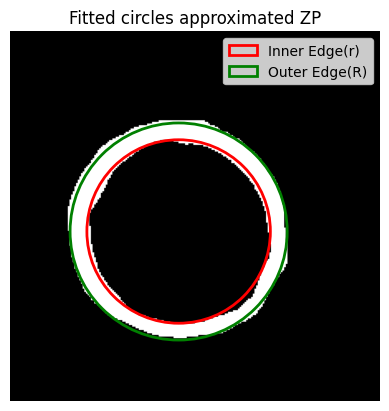

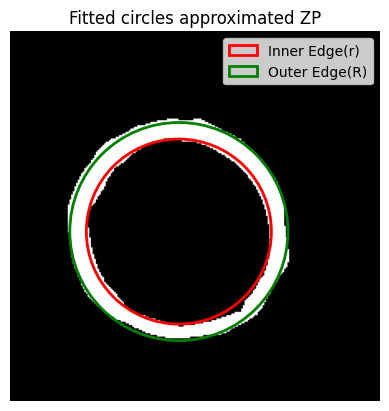

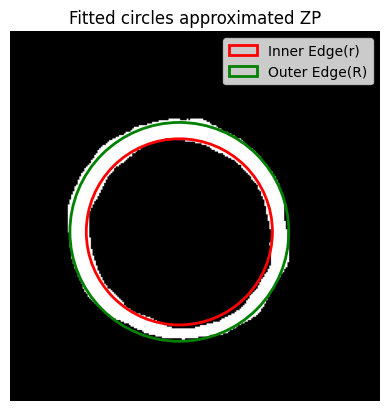

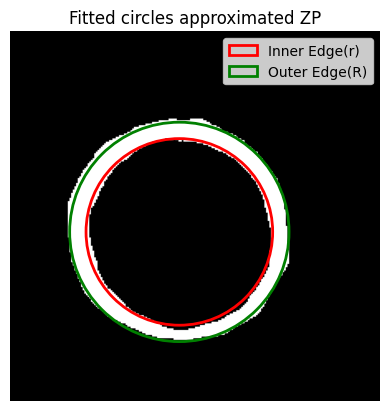

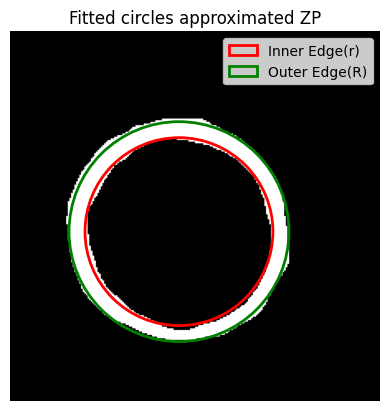

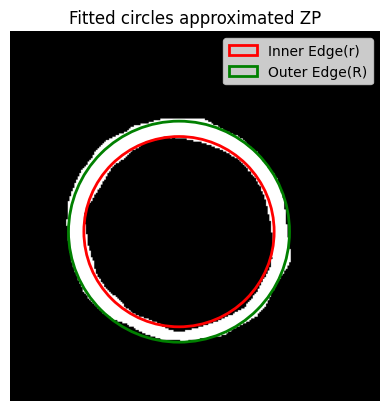

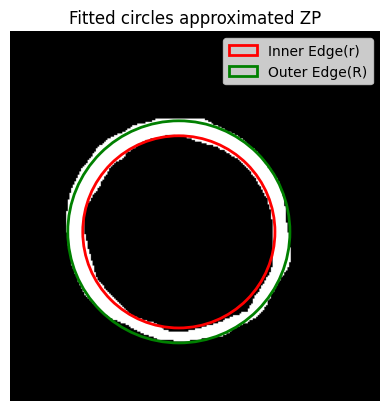

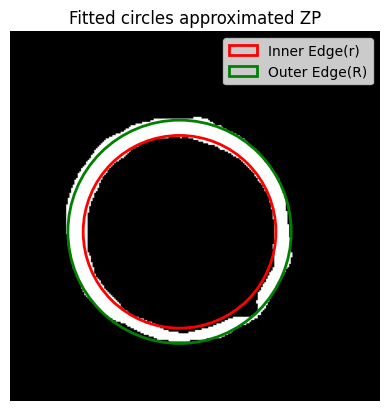

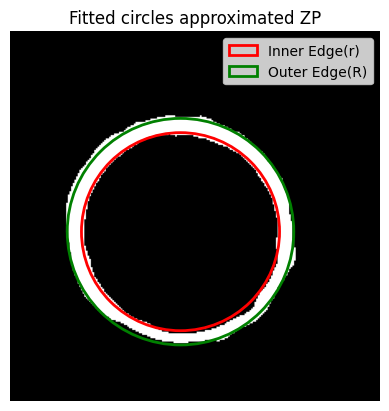

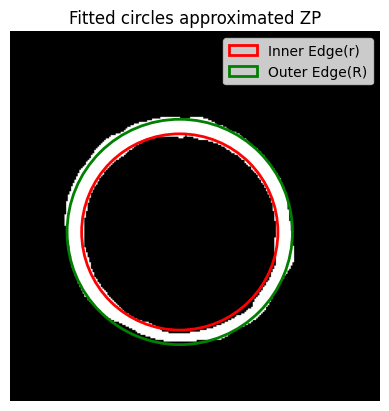

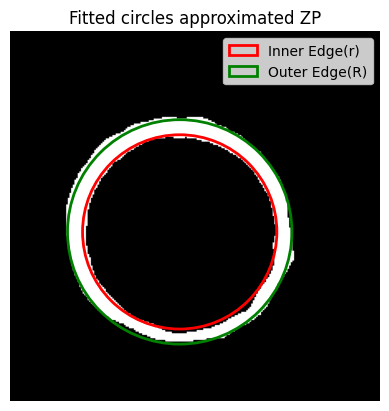

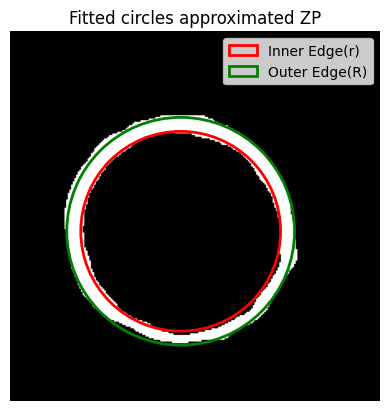

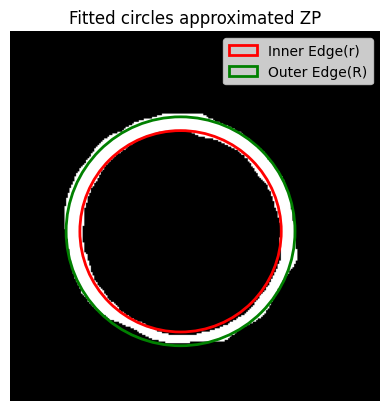

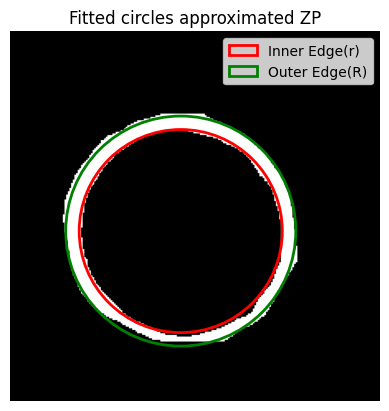

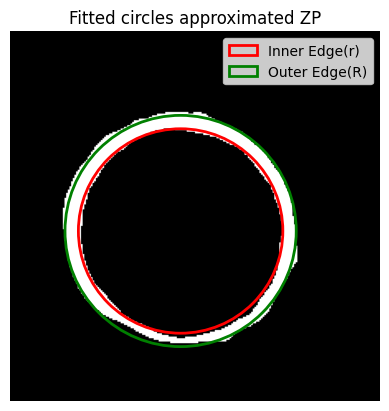

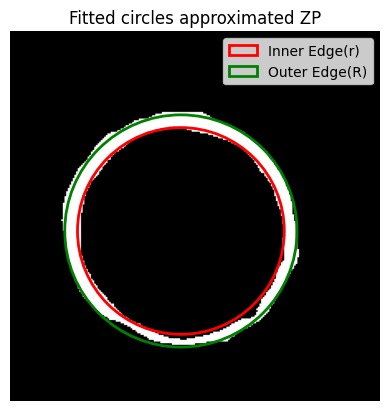

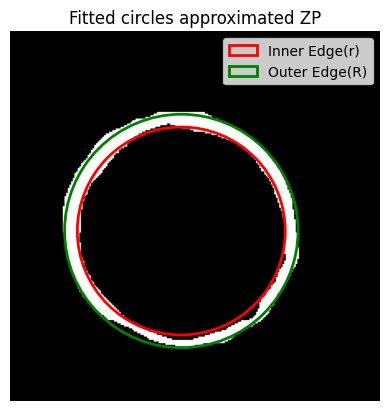

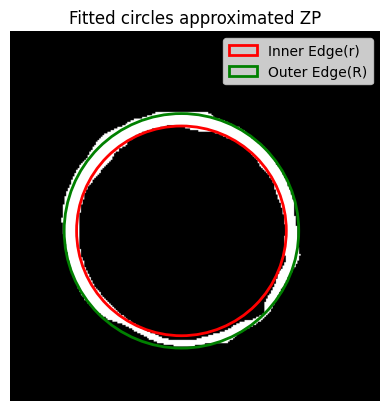

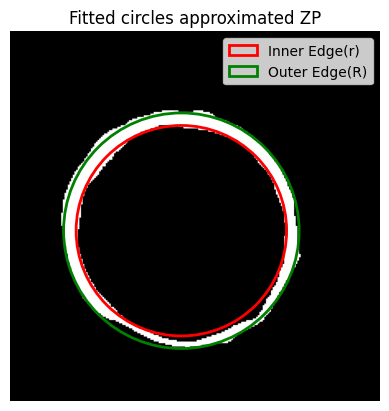

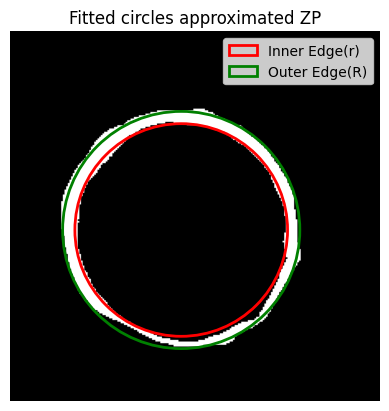

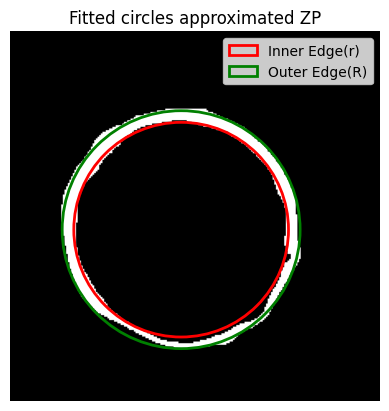

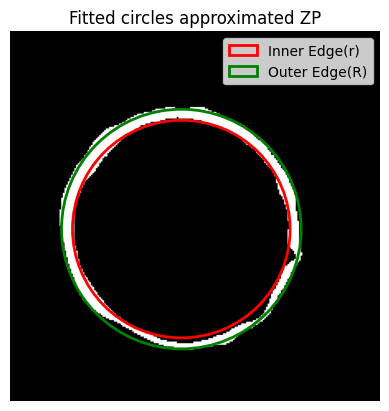

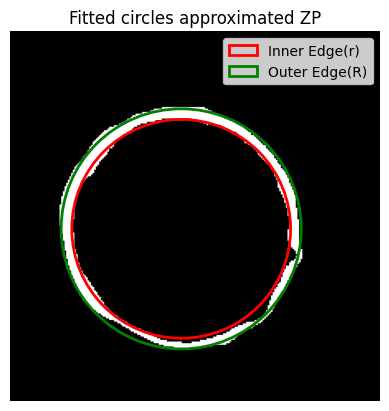

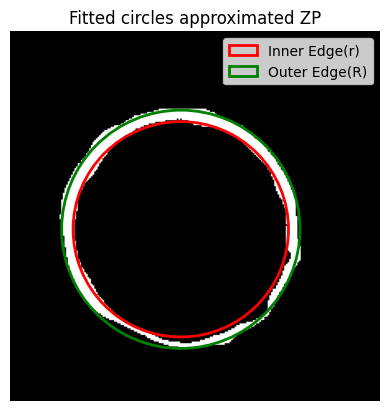

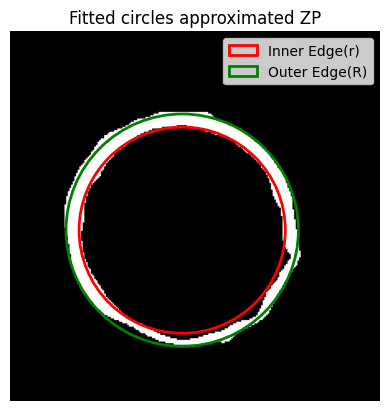

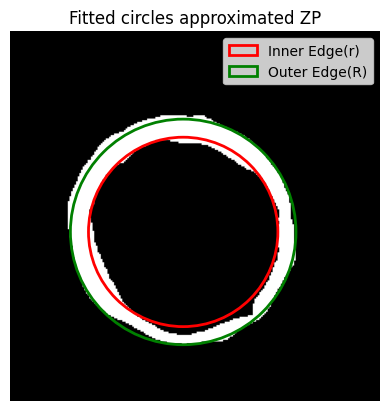

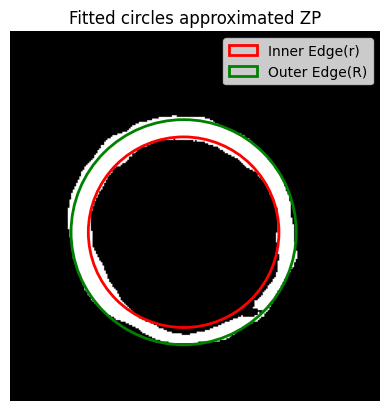

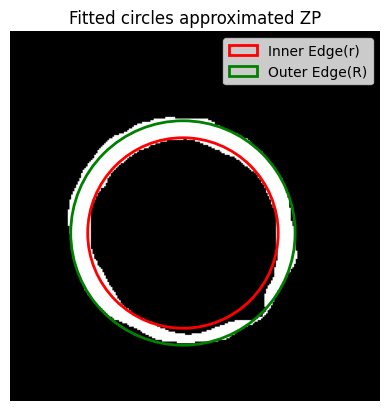

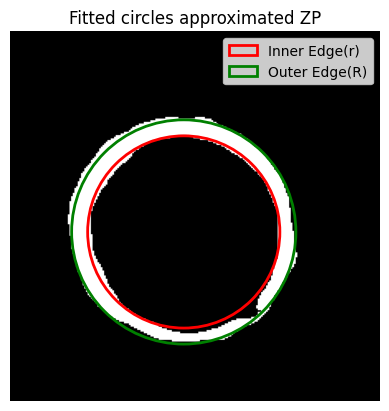

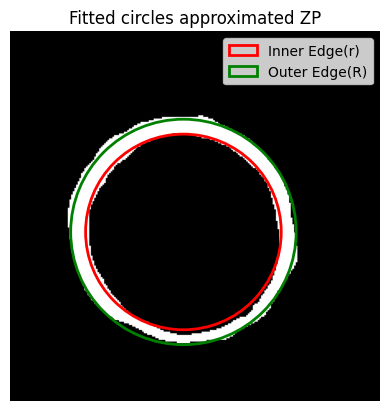

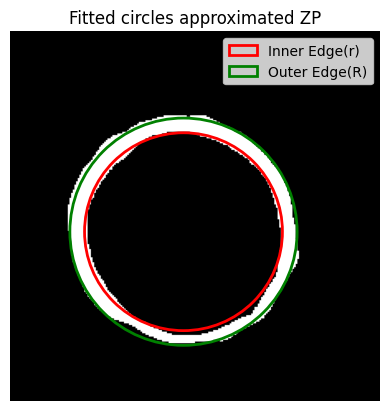

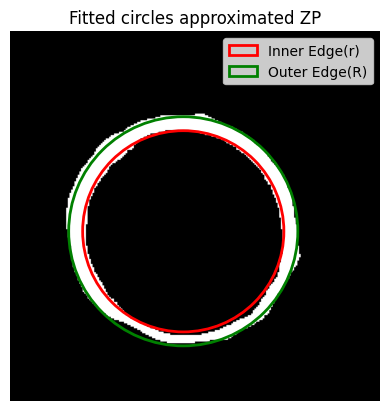

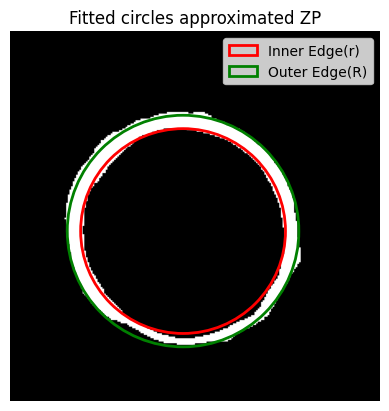

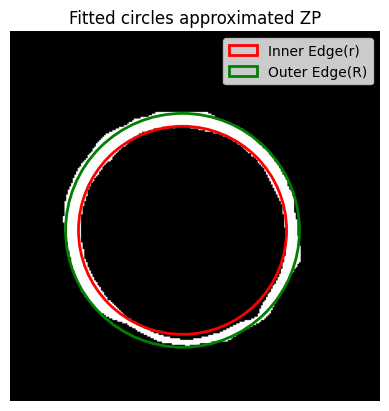

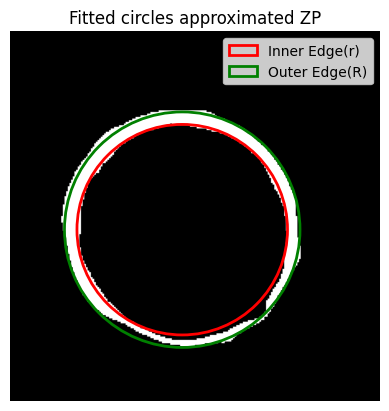

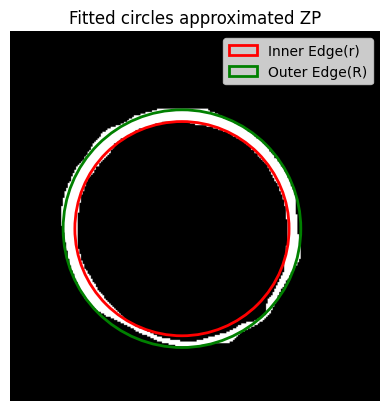

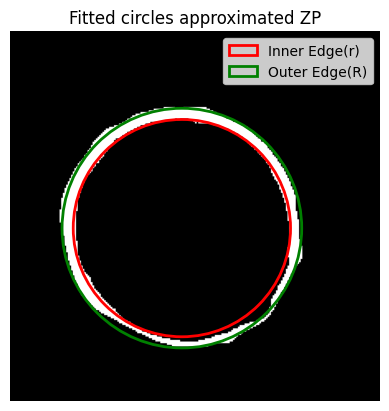

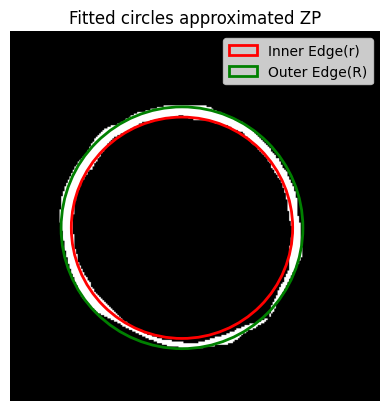

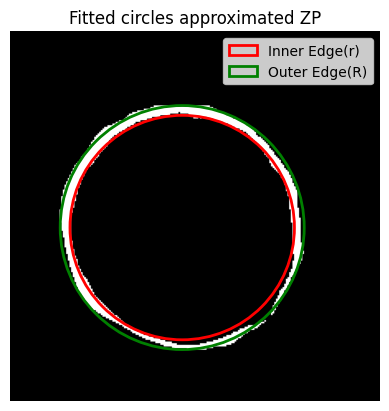

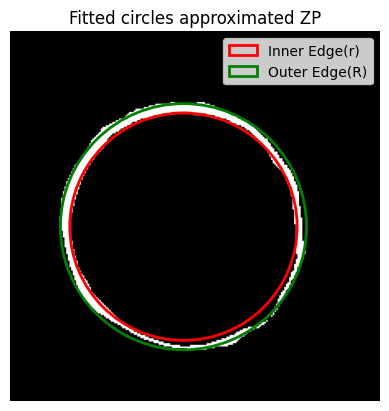

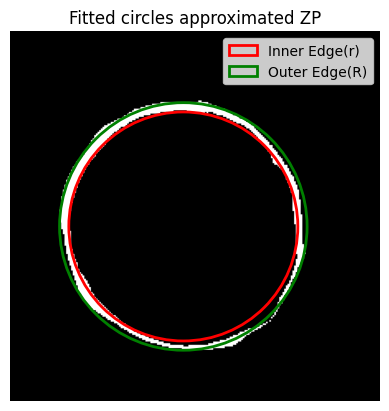

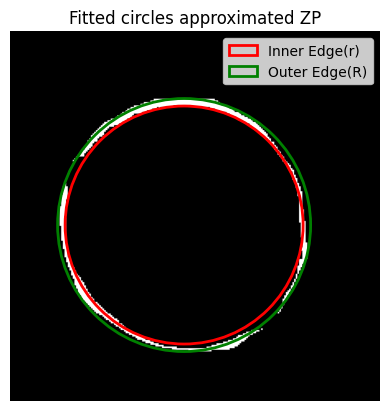

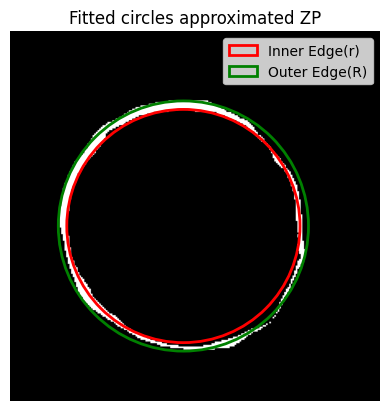

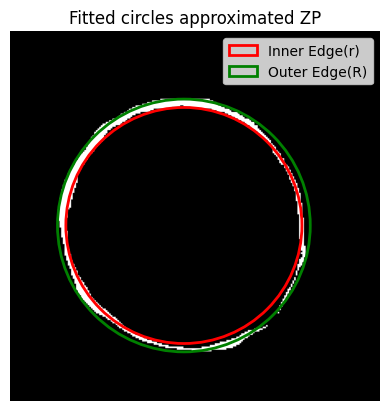

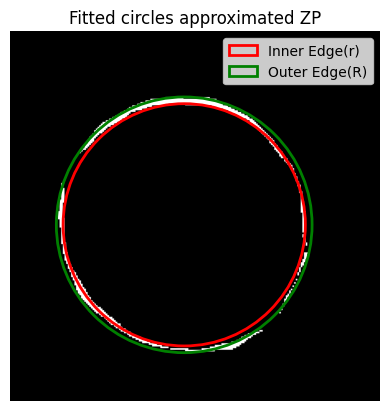

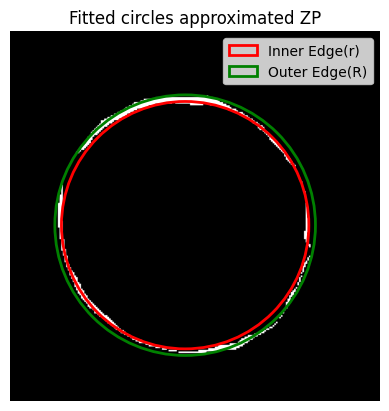

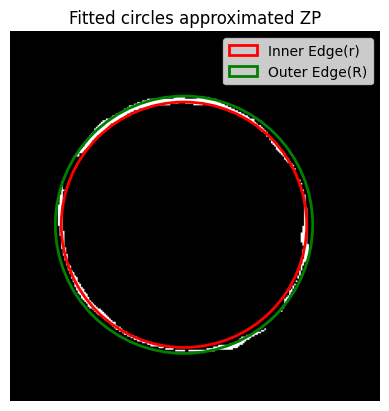

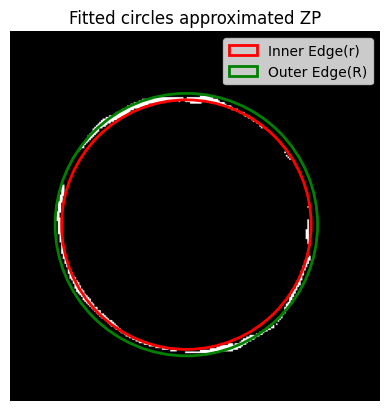

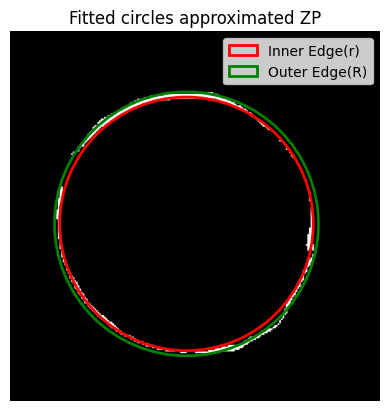

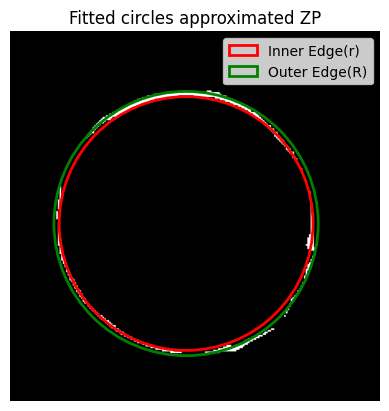

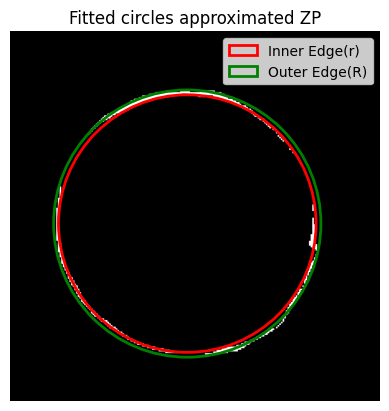

In [104]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

# Example: Create a sample image (or load your own)

image = np.random.random((300, 300))
for i in range(nframes):
    # Create a figure and axis
    fig, ax = plt.subplots()

    frame_res = fitted_results[i]

    # Display the image
    ax.imshow(all_masks[i][0]==1, cmap='gray')

    # Define the circle parameters: (x, y) center and radius
    circle = Circle(frame_res.circle_center, radius=frame_res.inner_radius, color='red', fill=False, linewidth=2)

    # Add the circle to the axes
    ax.add_patch(circle)
    circle = Circle(frame_res.circle_center, radius=frame_res.outer_radius, color='green', fill=False, linewidth=2)

    # Add the circle to the axes
    ax.add_patch(circle)

    # Optional: Turn off the axis for a cleaner look
    ax.axis('off')
    plt.title("Fitted circles approximated ZP")
    
    plt.legend(["Inner Edge(r)", "Outer Edge(R)"])
    # Show the plot
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib.patches import Circle

frames = []

for i in range(nframes):
    fig, ax = plt.subplots()
    frame_res = fitted_results[i]

    # Display the image
    ax.imshow(all_masks[i][0] == 1, cmap='gray')
    circle = Circle(frame_res.circle_center, radius=frame_res.inner_radius, color='red', fill=False, linewidth=2)

    # Add the circle to the axes
    ax.add_patch(circle)
    circle = Circle(frame_res.circle_center, radius=frame_res.outer_radius, color='green', fill=False, linewidth=2)

    # Add the circle to the axes
    ax.add_patch(circle)
    ax.set_title(f"Frame {i}")
    ax.axis('off')  # Remove axis for a cleaner image
    

    # Save the current frame as an image in memory
    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')  # Use buffer_rgba for compatibility
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # RGBA has 4 channels

    # Convert to an RGB PIL Image and add to frames list
    frames.append(Image.fromarray(frame[..., :3]))  # Drop the alpha channel (if not needed)

    plt.close(fig)  # Close the figure to avoid memory issues

# Save the frames as a GIF
frames[0].save('output.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)


In [105]:
def sphere_volume(r):
    return 4*np.pi*r**3/3

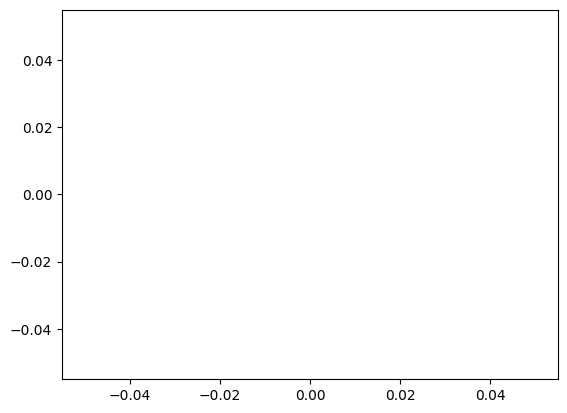

In [106]:
plt.plot(sphere_volume(np.array(outter_radii)))

plt.plot(sphere_volume(np.array(radii)))

In [107]:
plt.plot(np.gradient(sphere_volume(np.array(outter_radii))))

plt.plot(np.gradient(sphere_volume(np.array(radii))))

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

In [108]:

volume = sphere_volume(np.array(outter_radii)) - sphere_volume(np.array(radii))
volume_norm = (volume-volume.min())/(volume.max()-volume.min())


area_norm = (np.array(area)- np.min(area))/(np.max(area)- np.min(area))

ValueError: zero-size array to reduction operation minimum which has no identity

In [109]:
plt.plot(np.diff(area_norm))
plt.plot(np.diff(volume_norm))

NameError: name 'area_norm' is not defined

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# Generate a sample periodic signal
t = np.linspace(0, 20, len(np.diff(area_norm)))  # Time vector
y = np.gradient(area_norm)

from scipy.signal import correlate

# Compute autocorrelation
autocorr = correlate(y, y, mode="full")
lags = np.arange(-len(y) + 1, len(y))

# Plot autocorrelation
plt.figure(figsize=(8, 4))
plt.plot(lags, autocorr)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Function")
plt.show()


NameError: name 'area_norm' is not defined

In [111]:
    plt.plot(area_norm)
    plt.plot(volume_norm)

NameError: name 'area_norm' is not defined

In [112]:
sample_pth

PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

In [149]:
754-561


193

In [150]:
plt.scatter(area_norm, volume_norm)

NameError: name 'area_norm' is not defined

In [151]:
sample_pth


PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

In [152]:
plt.scatter(volume_norm, area_norm)

NameError: name 'volume_norm' is not defined

In [153]:
plt.plot(sphere_volume(np.array(outter_radii)) - sphere_volume(np.array(radii)))
# plt.plot(area)
plt.title("Volume of ZP (Shpere approximation)")
plt.xlabel("Timestep (since the beginning of expansion)")
plt.ylabel("Volume")


NameError: name 'sphere_volume' is not defined

In [154]:
sample_pth

PosixPath('../../data/extracted_masks/D2017.11.01_S01644_I0149_D_9')

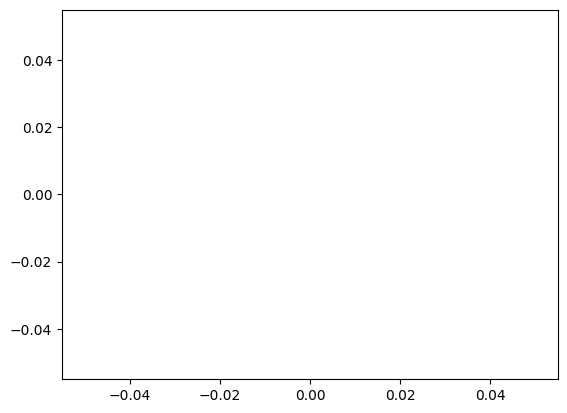

In [155]:
plt.plot((np.abs(np.diff(radii))+1)/(np.abs(np.diff(outter_radii))+1))

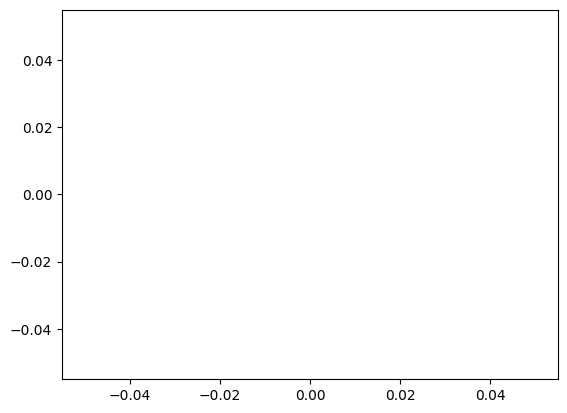

In [156]:
plt.plot(np.diff(radii))
plt.plot(np.diff(outter_radii))

Text(0, 0.5, 'Thickness')

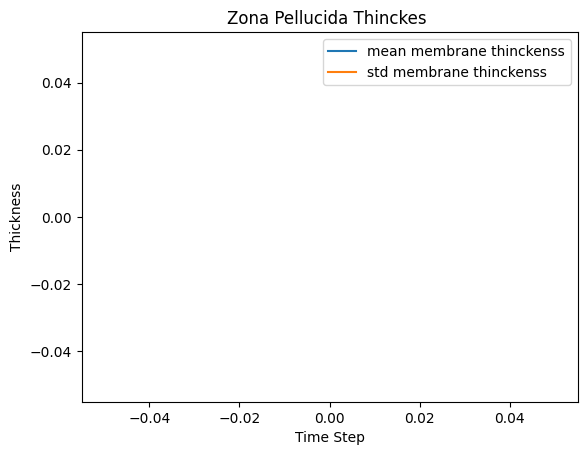

In [157]:
plt.plot(mean_thicknesses)
plt.plot(np.array(outter_radii)-np.array(radii))
plt.title('Zona Pellucida Thinckes ')
plt.legend(('mean membrane thinckenss','std membrane thinckenss'))
plt.xlabel('Time Step')
plt.ylabel('Thickness')

In [50]:
def calculate_stress(p: float, R:float, h: float) -> float:

    """
    p: float -> The pressure inisde the blastocyst
    R: float -> The radius of the blastocyst
    h: float -> the thickness of the ZP
    """
    
    return 2*p*R/(2*h)


def calculate_strain(h0: float, h: float) -> float:
    return (h0-h)/h0



def pressure_growth(p0: float, a: float, time_vector: np.ndarray) -> np.ndarray:

    return p0*(1+a*time_vector)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
R_gas = 8.314  # Universal gas constant (J/(mol*K))
T = 310  # Temperature in Kelvin (approx. 37°C)
k = 1e-2  # Permeability constant (arbitrary units)
P_osmotic = 3.0  # Osmotic pressure (kPa)
n_solute = 0.01  # Number of moles of solute (mol)
h0 = 10  # Initial thickness of ZP (microns)
E = 18  # Young's modulus (kPa)
h_min = 1  # Minimum allowable thickness (microns)
V0 = 1e3  # Initial blastocoel volume (microns^3)
dt = 0.1  # Time step (arbitrary units)
timesteps = 100  # Number of timesteps

# Initialize Variables
time = np.linspace(0, timesteps * dt, timesteps)
P = np.zeros(timesteps)  # Pressure in kPa
V = np.zeros(timesteps)  # Volume in microns^3
R = np.zeros(timesteps)  # Radius of the blastocoel (microns)
h = np.zeros(timesteps)  # Thickness of ZP (microns)
strain = np.zeros(timesteps)
stress = np.zeros(timesteps)

# Initial Conditions
P[0] = 0.1  # Initial pressure (kPa)
V[0] = V0
R[0] = (3 * V0 / (4 * np.pi))**(1/3)  # Initial radius of the blastocoel
h[0] = h0

# Time Evolution
for t in range(1, timesteps):
    # Fluid influx and volume update
    Q_in = k * (P_osmotic - P[t-1])  # Fluid influx rate
    V[t] = V[t-1] + Q_in * dt  # Update volume
    R[t] = (3 * V[t] / (4 * np.pi))**(1/3)  # Update radius

    # Stress calculation
    strain[t] = (h0 - h[t-1]) / h0
    stress[t] = E * strain[t]

    # Pressure update
    P[t] = (n_solute * R_gas * T) / V[t]

    # Thickness update (Laplace's law)
    h[t] = max((2 * stress[t] * R[t]) / P[t], h_min)  # Ensure h >= h_min

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(time, P[10:], label="Pressure (kPa)", lw=2)
# plt.plot(time, h, label="ZP Thickness (microns)", lw=2)
# plt.plot(time, R, label="Radius (microns)", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Blastocyst Expansion Dynamics")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, stress, label="Stress (kPa)", lw=2)
plt.plot(time, strain, label="Strain", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Stress and Strain Dynamics")
plt.legend()
plt.grid()
plt.show()


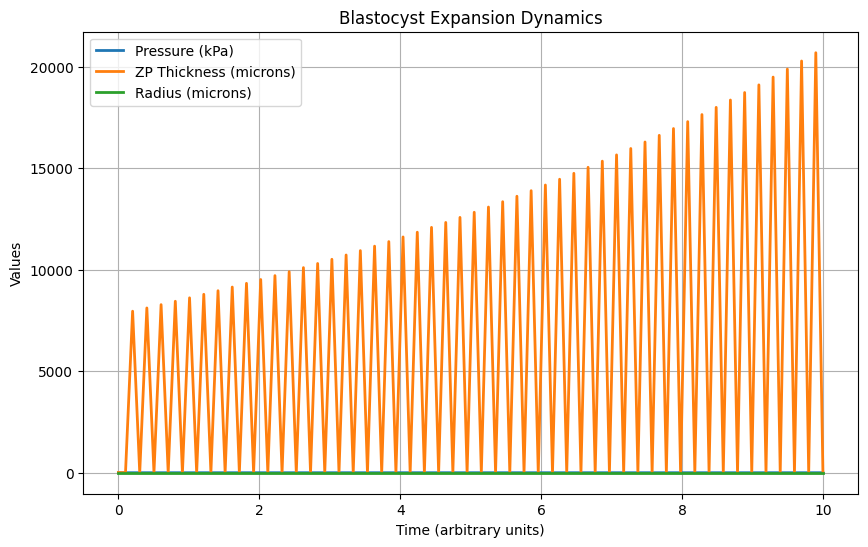

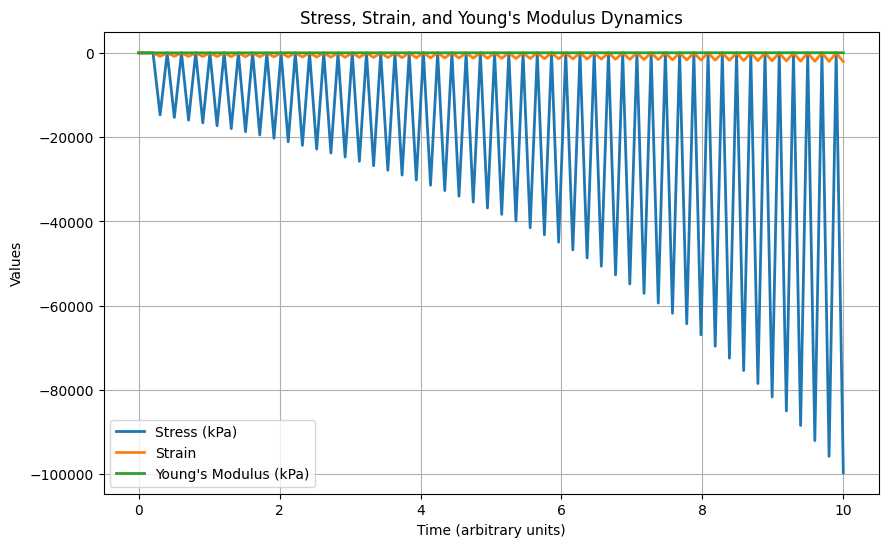

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and Parameters
R_gas = 8.314  # Universal gas constant (J/(mol*K))
T = 310  # Temperature in Kelvin (approx. 37°C)
k = 1e-2  # Permeability constant (arbitrary units)
P_osmotic = 3.0  # Osmotic pressure (kPa)
n_solute = 0.01  # Number of moles of solute (mol)
h0 = 10  # Initial thickness of ZP (microns)
E0 = 18  # Initial Young's modulus (kPa)
E_growth_rate = 0.01  # Growth rate of Young's modulus per timestep
h_min = 1  # Minimum allowable thickness (microns)
V0 = 1e3  # Initial blastocoel volume (microns^3)
dt = 0.1  # Time step (arbitrary units)
timesteps = 100  # Number of timesteps

# Initialize Variables
time = np.linspace(0, timesteps * dt, timesteps)
P = np.zeros(timesteps)  # Pressure in kPa
V = np.zeros(timesteps)  # Volume in microns^3
R = np.zeros(timesteps)  # Radius of the blastocoel (microns)
h = np.zeros(timesteps)  # Thickness of ZP (microns)
strain = np.zeros(timesteps)
stress = np.zeros(timesteps)
E = np.zeros(timesteps)  # Dynamic Young's modulus (kPa)

# Initial Conditions
P[0] = 0.1  # Initial pressure (kPa)
V[0] = V0
R[0] = (3 * V0 / (4 * np.pi))**(1/3)  # Initial radius of the blastocoel
h[0] = h0
E[0] = E0

# Time Evolution
for t in range(1, timesteps):
    # Update Young's modulus with growth rate
    E[t] = E[t-1] * (1 + E_growth_rate)

    # Fluid influx and volume update
    Q_in = k * (P_osmotic - P[t-1])  # Fluid influx rate
    V[t] = V[t-1] + Q_in * dt  # Update volume
    R[t] = (3 * V[t] / (4 * np.pi))**(1/3)  # Update radius

    # Stress calculation
    strain[t] = (h0 - h[t-1]) / h0
    stress[t] = E[t] * strain[t]

    # Pressure update
    P[t] = (n_solute * R_gas * T) / V[t]

    # Thickness update (Laplace's law)
    h[t] = max((2 * stress[t] * R[t]) / P[t], h_min)  # Ensure h >= h_min

# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(time, P, label="Pressure (kPa)", lw=2)
plt.plot(time, h, label="ZP Thickness (microns)", lw=2)
plt.plot(time, R, label="Radius (microns)", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Blastocyst Expansion Dynamics")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time, stress, label="Stress (kPa)", lw=2)
plt.plot(time, strain, label="Strain", lw=2)
plt.plot(time, E, label="Young's Modulus (kPa)", lw=2)
plt.xlabel("Time (arbitrary units)")
plt.ylabel("Values")
plt.title("Stress, Strain, and Young's Modulus Dynamics")
plt.legend()
plt.grid()
plt.show()


In [74]:
E_mu = 18
E_sigma = 2

R  = np.array(radii)
h0 = mean_thicknesses[0][0]
hs = h0 - np.array([m[0] for m in mean_thicknesses])#[1:]

ok_hs = hs>0

E_sample = np.random.normal(E_mu, E_sigma, (50,1000))

IndexError: list index out of range

In [197]:
# Define a linear elastic model
def stress_strain_model(strain, E):
    return E * strain


In [ ]:
pressure_levels*R*hs

In [147]:
pressure_levels = pressure_growth(p0, a_mu, t_vec)

stress_levels = calculate_stress(
                                pressure_levels[:,None][ok_hs], R[:,None][ok_hs],
                                hs[:,None][ok_hs]
                                    )

strain = hs[ok_hs]/h0

In [ ]:
plt.plot(stress_levels)

In [151]:
def stress_strain_model(strain, E):
    return E * strain


In [152]:
predicted_stress = stress_strain_model(strain, E_mu)

predicted_stress[predicted_stress<1] =1


In [ ]:
plt.plot(predicted_stress)

In [ ]:
predicted_h = (pressure_levels * R[1:,None][ok_hs]) / (2 * predicted_stress[:,None])

In [ ]:
predicted_h

In [156]:
from sklearn.metrics import mean_squared_error

In [ ]:
mses  = []
for i in range(50):

    
    mse = mean_squared_error(strain[10:], ((h0-predicted_h)/h0)[10:,i])
    predicted_strain = (h0-predicted_h)/h0
    mses.append(mse)
    plt.plot(strain[10:])
    plt.plot(((h0-predicted_h)/h0)[10:,i])

    plt.title("True Strain vs Predicted Strain")
    plt.xlabel("time")
    plt.ylabel("strain")
    plt.legend(['True Strain', 'Predicted Strain'])
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data (replace these with your actual data)
time = np.linspace(0, 10, 100)  # Time steps
thickness = 15 * np.exp(-0.1 * time) + 0.5  # Simulated thinning process

# Neo-Hookean model for thickness
# h(t) = h0 * exp(-C1 * t)
def neo_hookean_model(t, h0, C1):
    return h0 * np.exp(-C1 * t)

# Initial guess for parameters: h0 (initial thickness), C1 (decay rate)
initial_guess = [thickness[0], 0.1]

# Curve fitting
params, covariance = curve_fit(neo_hookean_model, time, thickness, p0=initial_guess)

# Extract fitted parameters
h0_fitted, C1_fitted = params

# Generate fitted curve
fitted_thickness = neo_hookean_model(time, h0_fitted, C1_fitted)

# Plot original data and fitted curve
plt.figure(figsize=(8, 5))
plt.scatter(time, thickness, label="Observed Data", color="blue")
plt.plot(time, fitted_thickness, label=f"Fitted Model\n$h_0$={h0_fitted:.2f}, $C_1$={C1_fitted:.2f}", color="red")
plt.title("Neo-Hookean Model Fit")
plt.xlabel("Time")
plt.ylabel("Thickness")
plt.legend()
plt.grid()
plt.show()

# Print fitted parameters
print(f"Fitted parameters:\n h0 (initial thickness) = {h0_fitted:.4f}\n C1 (decay rate) = {C1_fitted:.4f}")
plt.plot(pressure_levels, mses)